# Online Mooney study analysis



**Researchers: Claudia Damiano, Lore Goetschalckx, Johan Wagemans, Sander Van de Cruys**
___

Notes:
* All errorbars are **95% CIs**
* Even low correlations (<.1) seem to be significant for this amount of data (on alpha=.05). To properly correct for false positives, it will be important to distinguish hypothesis-based vs purely exploratory sections (the latter should use corrected alpha level). Prior hypotheses are described below.

For the study description see [paper draft](https://docs.google.com/document/d/1vk7sdP2iqzhYqGzLmZjfZh-50az_zWOWcGvTWNmRkqU/edit?usp=sharing).

203 mooney-solution pairs selected from pretest
212 participants (so far)

This study has three phases:

### Phase 1:

80 images per participant (no more than 3 from same category)

Measures:
- curiosity rating (pre-reveal)
- confidence rating (pre-reveal)
- guess: recognition pre-reveal, open answer (variable name: *guess*)
- did the participant make a guess (guess is not NA or empty string) for this trial/image? (variable name: *madeguess*)
- accuracy of guess (0/1) (variable name: *acc*)
- aha rating (post reveal)

### Phase 2:

80 old images (from phase 1), 20 new, unseen mooneys

Measures:
- Did you see mooney before (y/n): familiarity (variable name: *accfam*)
- Recognition memory: open answer (variable name: *guessmem*)
- Accuracy of recognition memory (0/1) (variable name: *accmem*)

### Phase 3:
Questionnaires (AQ-short, 5DCR, NCS, perceptual curiosity questionnaire)

### Key hypotheses

#### General
1. Is aha experience predictive of memory accuracy?
1. Is curiosity predictive of memory accuracy?
1. If so, is the link between curiosity & memory mediated by aha? (TODO)
1. What is the relation between confidence & curiosity/aha? (other studies suggest medium confidence is associated with highest curiosity)

#### Subject-based
1. Is a person's avg (state) curiosity measured in the task predictive of his/her general trait curiosity (5DCR + subscales)
1. Is a person's avg (state) curiosity measured in the task predictive of his/her general perceptual trait curiosity (perccur; not part of 5DCR))
1. Are autism traits linked to trait (5DCR) or (avg) state curiosity?
1. Are autism traits linked to trait (5DCR) or (avg) state curiosity?
1. Is the imagination subscale of AQ related to number of guesses (irrespective of accuracy), guess accuracy, or recognition memory? (rationale is about the generative process (cf. a form of imagination) required for solving a Mooney. We found a correlation between imagination and initial gues accuracy in a previous Mooney study.)

#### Image-based
1. Is image (avg) curiosity linked to image (avg) aha (and/or confidence)?
1. Is image (avg) aha/curiosity predictive of image recognition memory?
1. Which (if any) of the computed complexity measures is predictive of guess accuracy (pre-reveal) and/or memory accuracy and/or familiarity? 
1. Which (if any) of the computed complexity measures is predictive of curiosity/confidence/aha?
1. Does the structural similarity (mooney-solution) predict (memory) accuracy, familiarity or curiosity/aha? 
1. Do human memorability scores (memcat set) predict curiosity, aha, familiarity and/or recognition memory? (TODO)
1. Do NN memorability scores predict curiosity, aha, familiarity and/or recognition memory? (TODO)


Other things to try?
- d primes/bias on familiarity?
- consistency (across participants) of guesses/responses (irrespective of acc)?
- compute distance image position phase 1 to image pos in phase 2?

In [2]:
import glob, os #to work with paths
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt # roughly ~base R plotting functionality
import pandas as pd #roughly ~base R & tidyr functionality 
import seaborn as sns #roughly ~ggplot2 functionality
import scipy.stats  as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from fuzzywuzzy import fuzz
import warnings
warnings.filterwarnings('ignore')

#to make the plots appear inline, and saved in notebook:
%matplotlib inline
sns.set_context("talk") # seaborn function to make plots according to purpose (talk, paper, poster, notebook)

# We'll show people what version we use
import sys
print('Matplotlib Version: ' + mpl.__version__)
print('NumPy Version: ' + np.version.full_version)
print('Pandas Version:', pd.__version__)
print('Python Version: ' + sys.version)

import datetime
now  = datetime.datetime.now().isoformat()
print('Ran on ' + now)

Matplotlib Version: 3.2.1
NumPy Version: 1.18.2
Pandas Version: 1.0.3
Python Version: 3.7.3 (default, Oct  7 2019, 12:56:13) 
[GCC 8.3.0]
Ran on 2020-03-24T17:18:09.009211


In [4]:
!ls data/CO2020 #we can use shell commands to see where the data is (ls=dir on windows)

co00000.csv  co37693.csv  co38047.csv  co38293.csv  co38539.csv  co38857.csv
co29689.csv  co37708.csv  co38050.csv  co38296.csv  co38542.csv  co38917.csv
co34174.csv  co37720.csv  co38059.csv  co38299.csv  co38557.csv  co38929.csv
co37525.csv  co37723.csv  co38065.csv  co38314.csv  co38560.csv  co38938.csv
co37528.csv  co37783.csv  co38071.csv  co38317.csv  co38569.csv  co38956.csv
co37534.csv  co37795.csv  co38077.csv  co38326.csv  co38578.csv  co38959.csv
co37540.csv  co37801.csv  co38083.csv  co38350.csv  co38587.csv  co38974.csv
co37546.csv  co37840.csv  co38095.csv  co38353.csv  co38590.csv  co39040.csv
co37549.csv  co37855.csv  co38104.csv  co38356.csv  co38605.csv  co39112.csv
co37555.csv  co37864.csv  co38110.csv  co38359.csv  co38608.csv  co39139.csv
co37558.csv  co37873.csv  co38113.csv  co38365.csv  co38611.csv  co39184.csv
co37561.csv  co37876.csv  co38116.csv  co38368.csv  co38620.csv  co39211.csv
co37567.csv  co37882.csv  co38125.csv  co38389.csv  co38626.csv  co39250.csv

# Preprocessing routines

In [485]:
def preprocess(df):

    df.test_part = df.test_part.astype('category')

    # Make three dfs for 3 phases
    ph1 = df[df.test_part.isin(['post_mooney1_questions', 'recognition', 'post_reveal_questions'])]
    ph2 = df[df.test_part.isin(['ph2_recognition', 'familiar'])]
    quest = df[df.test_part.isin(['curiosity_questionnaire', 'sona'])]

    #extract dict values in responses
    ph1["responses"] = ph1["responses"].apply(lambda x : dict(eval(x)) )
    dfdict = ph1["responses"].apply(pd.Series)
    ph1 = ph1.join(dfdict)
    ph1 = ph1.reset_index()

    #get separate rts
    ph1['rtguess'] = np.where(ph1['test_part']=='recognition', ph1.rt, np.nan)
    ph1['rtaha'] = np.where(ph1['test_part']=='post_reveal_questions', ph1.rt, np.nan)
    ph1['rtcurcon'] = np.where(ph1['test_part']=='post_mooney1_questions', ph1.rt, np.nan)
    guesses = ph1[ph1.test_part=='recognition'][['currentStim','guess']]
    
    #reformat oneline per stim
    ph1 = ph1.groupby(['currentStim']).mean().reset_index()

    ph1 = ph1[['currentStim','curiosity', 'confidence','aha', 'rtguess', 'rtaha', 'rtcurcon']]
    ph1 = pd.merge(ph1, guesses, how='outer', on='currentStim')
    
    ph1["curiosity_z"] = stats.zscore(ph1["curiosity"])
    ph1["aha_z"] = stats.zscore(ph1["aha"])
    ph1["confidence_z"] = stats.zscore(ph1["confidence"])
    
    if len(ph1) != 80:
        print('deviant df length ph1')
    
    #Add phase2 (memory) data
    ph2 = ph2.reset_index()
    ph2['rtfamiliar'] = np.where(ph2['test_part']=='familiar', ph2.rt, np.nan)
    ph2['rtpostguess'] = np.where(ph2['test_part']=='ph2_recognition', ph2.rt, np.nan)
    
    fam = ph2[ph2.test_part=='familiar'][['currentStim','old','correct', 'rtfamiliar']]
    if len(fam)!=100:
        print('deviant df length fam')

    fam.old = np.where(fam.old=='y', True, False)
    
    fam = fam.rename(columns={"correct": "accfam"})
    ph1= pd.merge(ph1, fam, how='outer', on='currentStim')
        
    guess2 = ph2[ph2.test_part=='ph2_recognition'][['currentStim','responses', 'rtpostguess']]
    guess2["responses"] = guess2["responses"].apply(lambda x : dict(eval(x)) )
    dfdict = guess2["responses"].apply(pd.Series)
    guess2 = guess2.join(dfdict)
    guess2 = guess2.rename(columns={'recognition': 'guessmem'})
    guess2 = guess2.drop('responses', 1)
    if len(guess2)!=100:
        print('deviant df length guess2')
    ph1= pd.merge(ph1, guess2, how='outer', on='currentStim')

    if len(ph1)!=100:
        print('deviant df length final df')
    
    # add subject id/debrief/datajoin
    t = quest[quest.test_part=='sona'].responses.apply(lambda x : eval(x))
    subject = t.values[0][0]['value']
    debrief = t.values[0][1]['value']=="yes"
    datajoin = t.values[0][2]['value']=="yes"
    ph1['subject'] = [subject]*len(ph1)
    
    q = quest[quest.test_part=='curiosity_questionnaire'].responses.apply(lambda x : eval(x))
    qdict = q.apply(pd.Series)
    qdict['subject']= subject
    qdict['debrief'] = debrief
    qdict['datajoin'] = datajoin
    
    if subject != "co39274": # this participant did not fill out the questionnaires properly bc lack of time
        q = scorequestionnaires(qdict)
        ph1 = ph1.merge(q, how='left', on='subject')

    ph1.accfam = ph1.accfam.astype(int)
    ph1.debrief = ph1.debrief.astype(int)
    ph1.datajoin = ph1.datajoin.astype(int)
    ph1.old = ph1.old.astype(int) 
    
    ph1["guess"] = ph1["guess"].fillna(np.nan)
    ph1["guess"] = ph1["guess"].replace(r'^\s*$', np.nan, regex=True)
    ph1["guessmem"] = ph1["guessmem"].fillna(np.nan)
    ph1["guessmem"] = ph1["guessmem"].replace(r'^\s*$', np.nan, regex=True)
    ph1["acc"] = ph1[['currentStim', 'guess']].apply(correct, axis=1)
    ph1["accmem"] = ph1[['currentStim', 'guessmem']].apply(correct, axis=1)
    ph1["madeguess"]= np.where(ph1.guess.isnull(), 0, 1)


    print('participant', ph1['subject'].iloc[0], 'imported')
    
    return ph1

# Correcting open responses

In [63]:
answ = pd.read_csv("stimsAnswerKey_all.csv",delimiter='\t')
    
def correct(row):
    
    #print(row)
    img =  row['currentStim'][3:]
    labels= answ.labelsEn[answ['mooneys'] == img]
    labels= labels + ',' + answ.labelsNl[answ['mooneys'] == img]
    labels= labels.values[0].split(',')
    
    answer = row.iloc[ 1 ]
    
        
    acc = 0
    
    if not pd.isnull(answer):
        answer=answer.lower()

        #split answer into words
        answers = answer.split() 
        
        for i in labels:
            for j in answers:
                if fuzz.ratio(i.strip(),j.strip()) > 65:
                    acc=1
                    break
    #print(img,answer,labels[0],acc)
    return acc    


# Scoring questionnaires

In [172]:


def scorequestionnaires(df):

    revscored = [9,10,11,12,51,53,55,56,59,60,62,63,64,65,66,67,69,72]
    
    
    def score(items):
        sc = 0
        for (colName, colData) in items.iteritems():
            if int(colName) in revscored:
                colData = (6+1)-colData
            sc = sc+colData
        return sc
        
    # 1-24 5DCR Kashdan et al. 2020
    df['fiveDCR'] = score(df.iloc[:,:24])
    # 1-4 Joyous Exploration
    df['joyexp'] = score(df.iloc[:,:4])
    # 5-8 Deprivation Sensitivity
    df['deprsens'] = score(df.iloc[:,4:8])
    # 9-12 Stress Tolerance (reverse scored)
    df['stresstol']= score(df.iloc[:,8:12])
    # 13-16 overt social Curiosity
    df['ovsoccur']= score(df.iloc[:,12:16])
    # 17-20 covert social curiosity
    df['cosoccur']= score(df.iloc[:,16:20])
    # 21-24 Thrill seeking
    df['thrillseek']= score(df.iloc[:,20:24])
    # 25-34 Perceptual curiosity (add diversive vs specific subscale?)
    df['perccur']= score(df.iloc[:,24:34])
    # 35-49 Personal Need fo Closure Scale: Roets & van Hiel 2011: https://www.sciencedirect.com/science/article/abs/pii/S0191886910004344
    df['NCS']= score(df.iloc[:,34:49])
    # 50-77 Autism-quotient-short: Hoekstra et al 2011: https://link.springer.com/article/10.1007/s10803-010-1073-0 (check subscales?)
    df['AQ28']= score(df.iloc[:,49:77])
    # Soc skills subscale AQ
    df['socskills'] = score(df.iloc[:,49:56])
    # routine AQ
    df['routine'] = score(df.iloc[:,56:60])
    # switching AQ
    df['switching'] = score(df.iloc[:,60:64])
    # imagination AQ
    df['imagination'] = score(df.iloc[:,64:72])
    # numbers & patterns AQ
    df['numbpatt'] = score(df.iloc[:,72:77])
    
    return df

# all items for reference
qitems = {
      1: "I view challenging situations as an opportunity to grow and learn.",
      2: "I seek out situations where it is likely that I will have to think in depth about something.",
      3: "I enjoy learning about subjects that are unfamiliar to me.",
      4: "I find it fascinating to learn new information.",
      5: "Thinking about solutions to difficult conceptual problems can keep me awake at night.",
      6: "I can spend hours on a single problem because I just can't rest without knowing the answer.",
      7: "I feel frustrated if I can't figure out the solution to a problem, so I work even harder to solve it.",
      8: "I work relentlessly at problems that I feel must be solved.",
      9: "The smallest doubt can stop me from seeking out new experiences.",
      10: "I cannot handle the stress that comes from entering uncertain situations.",
      11: "I find it hard to explore new places when I lack confidence in my abilities.",
      12: "It is difficult to concentrate when there is a possibility that I will be taken by surprise.",
      13: "I ask a lot of questions to figure out what interests other people.",
      14: "When talking to someone who is excited, I am curious to find out why.",
      15: "When talking to someone, I try to discover interesting details about them.",
      16: "I like finding out why people behave the way they do.",
      17: "When other people are having a conversation, I like to find out what it's about.",
      18: "When around other people, I like listening to their conversations.",
      19: "When people quarrel, I like to know what's going on.",
      20: "I seek out information about the private lives of people in my life.",
      21: "Risk-taking is exciting to me.",
      22: "When I have free time, I want to do things that are a little scary.",
      23: "Creating an adventure as I go is much more appealing than a planned adventure.",
      24: "I prefer friends who are excitingly unpredictable.",
      25: "I like exploring my surroundings.",
      26: "When I smell something new, I try and find out what the odor is coming from.",
      27: "I like to discover new places to go.",
      28: "If I hear something rustling in the grass I have to see what it is.",
      29: "I like visiting art galleries and art museums.",
      30: "When I see a new fabric, I like to touch and feel it.",
      31: "I like to listen to new and unusual kinds of music.",
      32: "When I hear a musical instrument and I am not sure what it is, I like to see it.",
      33: "I enjoy trying different kinds of ethnic foods.",
      34: "When I hear a strange sound, I usually try to find out what caused it.",
      35: "I don’t like situations that are uncertain.",
      36: "I dislike questions which could be answered in many different ways.",
      37: "I find that a well ordered life with regular hours suits my temperament.",
      38: "I feel uncomfortable when I don’t understand the reason why an event occurred in my life.",
      39: "I feel irritated when one person disagrees with what everyone else in a group believes.",
      40: "I don’t like to go into a situation without knowing what I can expect from it.",
      41: "When I have made a decision, I feel relieved.",
      42: "When I am confronted with a problem, I’m dying to reach a solution very quickly.",
      43: "I would quickly become impatient and irritated if I would not find a solution to a problem immediately.",
      44: "I don’t like to be with people who are capable of unexpected actions.",
      45: "I dislike it when a person’s statement could mean many different things.",
      46: "I find that establishing a consistent routine enables me to enjoy life more.",
      47: "I enjoy having a clear and structured mode of life.",
      48: "I do not usually consult many different opinions before forming my own view.",
      49: "I dislike unpredictable situations.",
      50: "I prefer to do things with others rather than on my own.",
      51: "I find social situations easy.",
      52: "I would rather go to a library than to a party.",
      53: "I find myself drawn more strongly to people than to things.",
      54: "I find it hard to make new friends.",
      55: "I enjoy social occasions.",
      56: "I enjoy meeting new people.",
      57: "New situations make me anxious.",
      58: "I prefer to do things the same way over and over again.",
      59: "It does not upset me if my daily routine is disturbed.",
      60: "I enjoy doing things spontaneously.",
      61: "I frequently get strongly absorbed in one thing.",
      62: "I can easily keep track of several different people’s conversations.",
      63: "I find it easy to do more than one thing at once.",
      64: "If there is an interruption, I can switch back very quickly.",
      65: "Trying to imagine something, I find it easy to create a picture in my mind.",
      66: "Reading a story, I can easily imagine what the characters might look like.",
      67: "I find making up stories easy.",
      68: "Reading a story, I find it difficult to work out the character’s intentions.",
      69: "I find it easy to work out what someone is thinking or feeling.",
      70: "I find it difficult to imagine what it would be like to be someone else.",
      71: "I find it difficult to work out people’s intentions.",
      72: "I find it easy to play games with children that involve pretending.",
      73: "I usually notice car number plates or similar strings of information.",
      74: "I am fascinated by dates.",
      75: "I am fascinated by numbers.",
      76: "I notice patterns in things all the time.",
      77: "I like to collect information about categories of things.",
    }


# Read in data files

In [486]:
df = pd.DataFrame()

all_files = glob.glob(os.path.join('data/CO2020', "*.csv")) # get list of individual data files
print(len(all_files), 'files')

for f in all_files:
    #print(f)
    thisdf = pd.read_csv(f, index_col='trial_index')
    thisdf = preprocess(thisdf)
    df = pd.concat([df,thisdf], ignore_index=True)
   
    
print('Variables:\n', df.columns)
print('variables:\n', df.dtypes)
print('nb of participants:', len(df['subject'].unique()))
print(len(df))

df.to_csv('df.csv')
df.head()

212 files
participant 38755 imported
participant 37954 imported
participant 38857 imported
participant 38956 imported
participant 37555 imported
participant 38212 imported
participant 37669 imported
participant 39754 imported
participant 38065 imported
participant 38116 imported
participant 37903 imported
participant 39502 imported
participant 38626 imported
participant 38350 imported
participant 38272 imported
participant 37663 imported
participant 37618 imported
participant 38539 imported
participant 39823 imported
participant 37690 imported
participant 37795 imported
participant 38674 imported
participant 37873 imported
participant 37558 imported
participant 00000 imported
participant 38356 imported
participant 37999 imported
participant 38083 imported
participant 38158 imported
participant 37801 imported
participant 38620 imported
participant 38710 imported
participant 38104 imported
participant 38701 imported
participant 38503 imported
participant CA imported
participant 37990 imp

currentStim  curiosity  confidence  aha  rtguess     rtaha  \
0  ../img/tt/007tt.jpg        2.0         1.0  2.0  2766.09  3889.175   
1  ../img/tt/010tt.jpg        1.0         0.0  1.0  4542.04  1845.540   
2  ../img/tt/019tt.jpg        1.0         3.0  0.0  1950.08  3785.400   
3  ../img/tt/020tt.jpg        3.0         2.0  1.0  6766.01  1569.050   
4  ../img/tt/036tt.jpg        5.0         1.0  4.0  4045.96  4494.610   

   rtcurcon     guess  curiosity_z     aha_z  ...  NCS  AQ28  socskills  \
0  4343.400      spin    -0.425118 -0.097383  ...   45    93         23   
1  9312.725      fish    -1.216035 -0.805625  ...   45    93         23   
2  2592.060      tang    -1.216035 -1.513867  ...   45    93         23   
3  5623.535  kameleon     0.365799 -0.805625  ...   45    93         23   
4  5588.395      tree     1.947633  1.319101  ...   45    93         23   

   routine  switching imagination numbpatt  acc  accmem  madeguess  
0       13         18          28       11    0       1       True  
1       13         18          28       11    0       0       True  
2       13         18          28       11    1       1       True  
3       13         18          28       11    0       0       True  
4       13         18          28       11    0       1       True  

[5 rows x 114 columns]

# Overall descriptives

In [489]:
df[df.old==1].describe()

curiosity    confidence           aha       rtguess         rtaha  \
count  16960.000000  16960.000000  16960.000000  16960.000000  1.696000e+04   
mean       3.871403      1.822288      3.288384   3387.832808  3.982037e+03   
std        1.711012      1.780223      1.968148   3107.638148  8.865457e+04   
min        0.000000      0.000000      0.000000    142.100000  9.315200e+02   
25%        3.000000      0.000000      2.000000   1597.955000  2.177704e+03   
50%        4.000000      1.000000      4.000000   2733.940000  2.799863e+03   
75%        5.000000      3.000000      5.000000   4142.200000  3.664068e+03   
max        6.000000      6.000000      6.000000  70373.835000  1.153142e+07   

           rtcurcon   curiosity_z         aha_z  confidence_z      old  ...  \
count  1.696000e+04  1.688000e+04  1.696000e+04  1.696000e+04  16960.0  ...   
mean   5.837697e+03 -1.120746e-17 -2.775558e-18  9.216946e-18      1.0  ...   
std    2.782579e+04  1.000030e+00  1.000029e+00  1.000029e+00      0.0  ...   
min    1.771135e+03 -6.336253e+00 -4.335831e+00 -2.474930e+00      1.0  ...   
25%    3.925460e+03 -6.241251e-01 -7.999574e-01 -7.958406e-01      1.0  ...   
50%    4.856588e+03  1.658932e-01  1.855485e-01 -2.063290e-01      1.0  ...   
75%    6.288974e+03  6.671683e-01  7.921319e-01  6.611549e-01      1.0  ...   
max    3.479680e+06  8.888194e+00  4.082483e+00  4.535209e+00      1.0  ...   

            perccur           NCS          AQ28     socskills       routine  \
count  16960.000000  16960.000000  16960.000000  16960.000000  16960.000000   
mean      33.047170     42.221698     85.061321     21.867925     13.400943   
std        6.448654      9.432904     11.583552      4.710776      3.274439   
min        0.000000      0.000000     54.000000     12.000000      5.000000   
25%       29.000000     37.000000     77.000000     18.000000     11.000000   
50%       33.000000     42.000000     85.000000     22.000000     13.500000   
75%       38.000000     48.000000     93.000000     25.000000     16.000000   
max       50.000000     66.000000    132.000000     37.000000     23.000000   

          switching   imagination      numbpatt           acc        accmem  
count  16960.000000  16960.000000  16960.000000  16960.000000  16960.000000  
mean      15.466981     22.995283     11.330189      0.218337      0.578892  
std        2.829152      5.084808      4.031181      0.413130      0.493751  
min        7.000000     11.000000      0.000000      0.000000      0.000000  
25%       13.750000     20.000000      9.000000      0.000000      0.000000  
50%       15.000000     23.000000     11.000000      0.000000      1.000000  
75%       17.000000     26.000000     14.000000      0.000000      1.000000  
max       26.000000     43.000000     21.000000      1.000000      1.000000  

[8 rows x 109 columns]

### Missing data? 

to be expected: lack of guesses + trials of new images (phase 2) don't have phase 1 scores

In [490]:
df.isnull().sum()

currentStim       0
curiosity      4240
confidence     4240
aha            4240
rtguess        4240
               ... 
imagination       0
numbpatt          0
acc               0
accmem            0
madeguess         0
Length: 114, dtype: int64

There was one subject (37570) *always* answered 6 on curiosity (so curiosity_z= NA). We'll remove him/her just to work with complete data.

In [465]:
df = df[df.subject!='37570']

# Explore main variable relations

We limit most analysis to the trials of images that appeared in both phases (these rows are complete, ie also have aha/curiosity/acc/confidence measures)
For the second phase dependent variables (recognition memory, familiarity), we usually look at trials where people were inaccurate in their initial guess only. The reason is that aha will have a different meaning (it's performance affect, ie "I did well!", instead of just the "goodness of fit"). We will look at this effect of accuracy below.

In [503]:
dfo= df[(df.old==1)] # only images that appeared in both phases
dfp= df[(df.old==1) & (df.acc==0)] # only images that appeared in both phases and were not accurately recognized in phase 1.

print("percentage of used trials:", len(dfp)/len(dfo))

percentage of used trials: 0.7816627358490567


### Lack of guesses

In [504]:
dfo.guess.isnull().sum()

4152

In [505]:
print('percentage of trials without guess:',dfo.guess.isnull().sum()/len(dfo.guess))

percentage of trials without guess: 0.24481132075471698


We will look at both raw scale data and z-transformed (person-based) scale data.

## Is there a link between confidence and curiosity?

pearson r = -0.33 p-value =  0.0


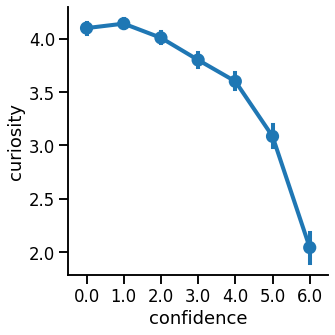

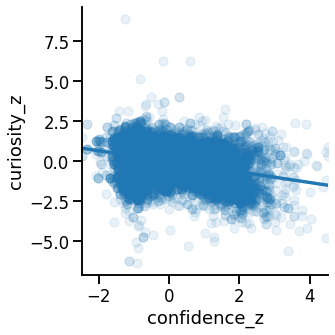

In [467]:
sns.catplot(x="confidence", y="curiosity",
            kind="point", data=dfo);

sns.lmplot(x="confidence_z", y="curiosity_z", scatter_kws={'alpha':0.1}, data=dfo);

r, p = stats.pearsonr(dfo.confidence_z, dfo.curiosity_z)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes, a significant negative one. More confidence means less curiosity. Interestingly, other studies find intermediate confidence to be eliciting most curiosity. Is this moderated by accuracy of the guess?

Incorrect guess: pearson r = -0.185 p-value =  0.0
Correct guess: pearson r = -0.433 p-value =  0.0


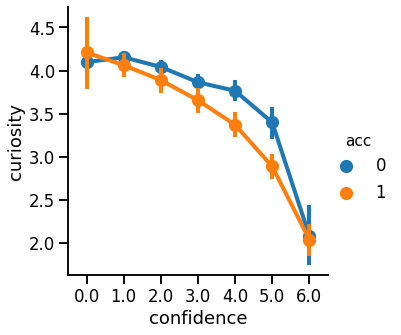

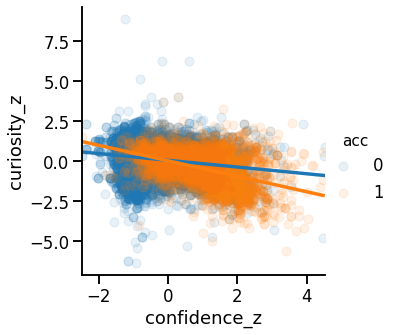

In [468]:
sns.catplot(x="confidence", y="curiosity",
            kind="point",hue='acc', data=dfo);

sns.lmplot(x="confidence_z", y="curiosity_z", hue='acc', scatter_kws={'alpha':0.1}, data=dfo);

r, p = stats.pearsonr(dfo[dfo.acc==0].confidence_z, dfo[dfo.acc==0].curiosity_z)
print('Incorrect guess: pearson r =', round(r,3), 'p-value = ', round(p,3))
r, p = stats.pearsonr(dfo[dfo.acc==1].confidence_z, dfo[dfo.acc==1].curiosity_z)
print('Correct guess: pearson r =', round(r,3), 'p-value = ', round(p,3))

Negative correlation is (evidently) stronger for correct guesses. 

## Does curiosity (pre-reveal) predict the strength of aha-experience (post-reveal)?

pearson r = 0.295 p-value =  0.0


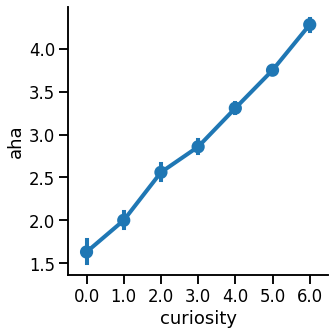

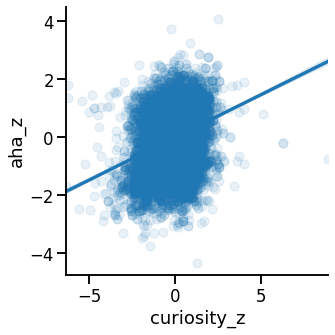

In [469]:
sns.catplot(x="curiosity", y="aha",
            kind="point", data=dfo);

sns.lmplot(x="curiosity_z", y="aha_z", scatter_kws={'alpha':0.1}, data=dfo);

r, p = stats.pearsonr(dfo.curiosity_z, dfo.aha_z)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes, it does, significantly and positively, suggesting that people can to some extent predict their aha experience. Is it moderated by guess accuracy?

Incorrect guess: pearson r = 0.184 p-value =  0.0
Correct guess: pearson r = 0.363 p-value =  0.0


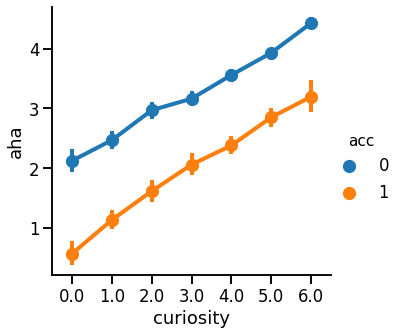

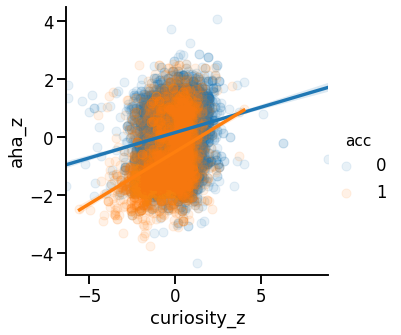

In [470]:
sns.catplot(x="curiosity", y="aha",
            kind="point",hue='acc', data=dfo);

sns.lmplot(x="curiosity_z", y="aha_z", hue='acc', scatter_kws={'alpha':0.1}, data=dfo);

r, p = stats.pearsonr(dfo[dfo.acc==0].curiosity_z, dfo[dfo.acc==0].aha_z)
print('Incorrect guess: pearson r =', round(r,3), 'p-value = ', round(p,3))
r, p = stats.pearsonr(dfo[dfo.acc==1].curiosity_z, dfo[dfo.acc==1].aha_z)
print('Correct guess: pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes, if you're accurate aha increases even more with curiosity.

## Does confidence predict aha experience?

pearson r = -0.259 p-value =  0.0


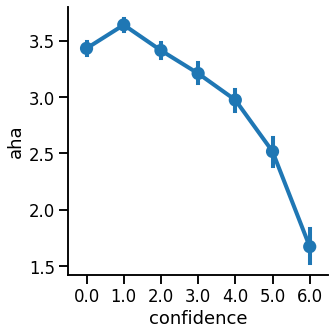

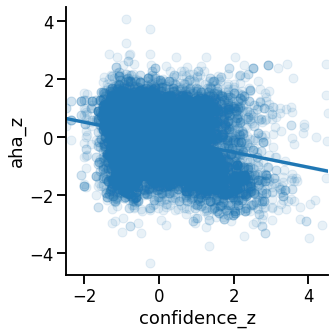

In [471]:
sns.catplot(x="confidence", y="aha",
            kind="point", data=dfo);

sns.lmplot(x="confidence_z", y="aha_z", scatter_kws={'alpha':0.1}, data=dfo);

r, p = stats.pearsonr(dfo.confidence_z, dfo.aha_z)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes, it does, significantly and negatively: more confidence, less aha. Moderated by guess accuracy?

Incorrect guess: pearson r = -0.016 p-value =  0.06615
Correct guess: pearson r = -0.31 p-value =  0.0


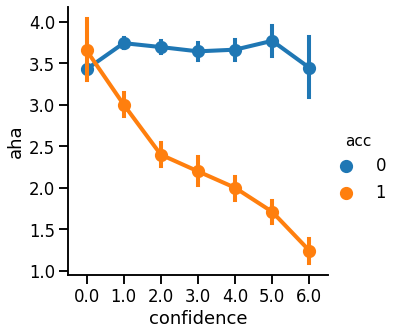

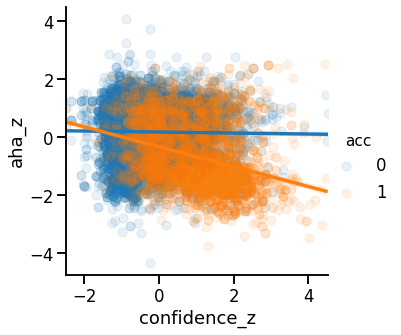

In [472]:
sns.catplot(x="confidence", y="aha",
            kind="point",hue='acc', data=dfo);

sns.lmplot(x="confidence_z", y="aha_z", hue='acc', scatter_kws={'alpha':0.1}, data=dfo);

r, p = stats.pearsonr(dfo[dfo.acc==0].confidence_z, dfo[dfo.acc==0].aha_z)
print('Incorrect guess: pearson r =', round(r,3), 'p-value = ', round(p,5))
r, p = stats.pearsonr(dfo[dfo.acc==1].confidence_z, dfo[dfo.acc==1].aha_z)
print('Correct guess: pearson r =', round(r,3), 'p-value = ', round(p,5))

Only for accurate guesses, aha really goes down with confidence, ie if you were highly confident of your guess and it turned out to be right, you have decreased aha (solution was too obvious). If your guess was inaccurate, your confidence about it does not matter much in the aha experience, ie if you were highly confident of an inaccurate guess, there is no cost or benefit in aha. However, what if we limit the analysis to trials for which an actual guess was made?

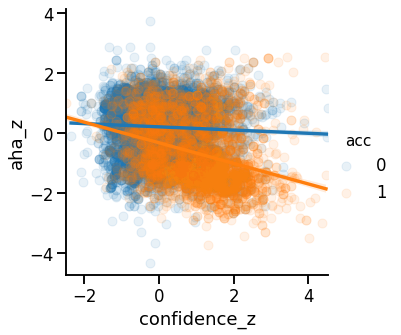

In [509]:
sns.lmplot(x="confidence_z", y="aha_z", hue='acc', scatter_kws={'alpha':0.1}, data=dfo[dfo.madeguess==1]);

Very similar.

## Does confidence predict accuracy (sanity check)?

pearson r = 0.507 p-value =  0.0


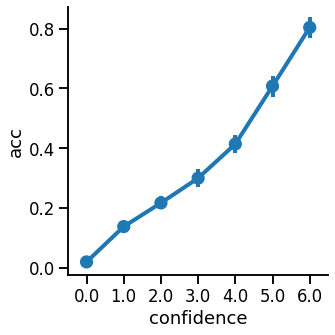

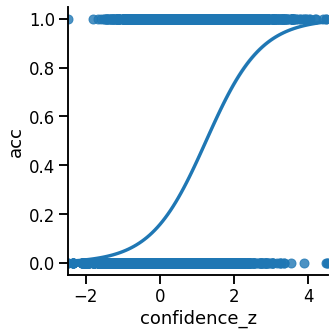

In [473]:
sns.catplot(x="confidence", y="acc",
            kind="point", data=dfo);
sns.lmplot(x="confidence_z", y="acc", data=dfo, logistic=True);

r, p = stats.pearsonr(dfo.confidence_z, dfo.acc)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes, it does so strongly (starting from a participants' mean confidence), as expected.

## Does curiosity link with accuracy?

pearson r = -0.227 p-value =  0.0


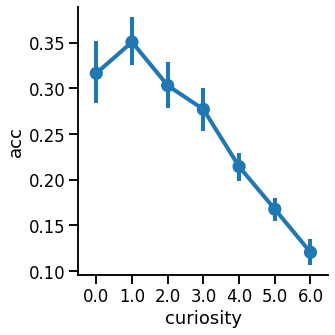

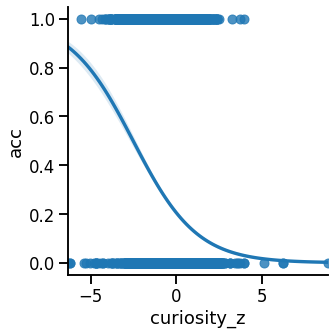

In [474]:
sns.catplot(x="curiosity", y="acc",
            kind="point", data=dfo);
sns.lmplot(x="curiosity_z", y="acc", data=dfo, logistic=True);

r, p = stats.pearsonr(dfo.curiosity_z, dfo.acc)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes, as expected, lower accuracy means higher curiosity

## Does accuracy (pre-reveal) predict aha (post-reveal)?

pearson r = -0.346 p-value =  0.0


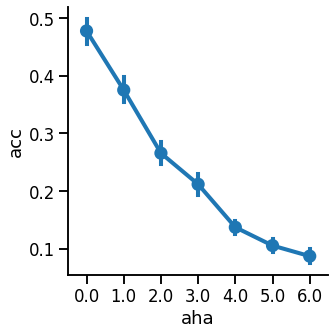

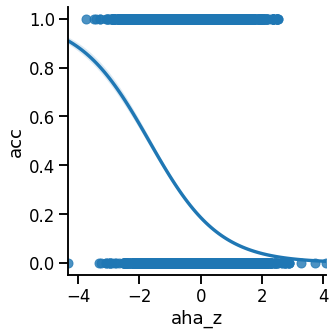

In [475]:
sns.catplot(x="aha", y="acc",
            kind="point", data=dfo);
sns.lmplot(x="aha_z", y="acc", data=dfo, logistic=True);

r, p = stats.pearsonr(dfo.aha_z, dfo.acc)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes, as expected, lower accuracy is linked to higher aha

## Does confidence predict familiarity?

pearson r = 0.186 p-value =  0.0


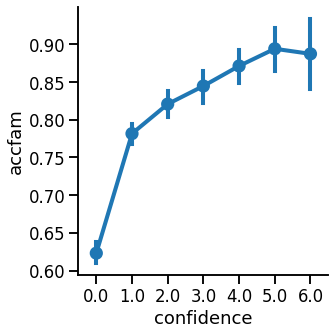

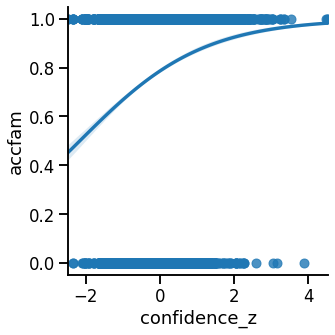

In [476]:
sns.catplot(x="confidence", y="accfam",
            kind="point", data=dfp);
sns.lmplot(x="confidence_z", y="accfam", data=dfp, logistic=True);

r, p = stats.pearsonr(dfp.confidence_z, dfp.accfam)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes: more confidence, more accurate familiarity judgment.

## Does curiosity predict familiarity?

pearson r = 0.007 p-value =  0.393


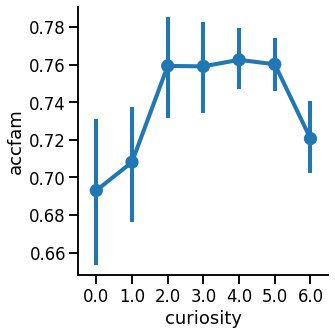

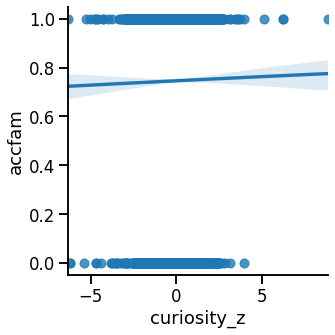

In [477]:
sns.catplot(x="curiosity", y="accfam",
            kind="point", data=dfp);
sns.lmplot(x="curiosity_z", y="accfam", data=dfp, logistic=True);

r, p = stats.pearsonr(dfp.curiosity_z, dfp.accfam)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Not really, except maybe for the most extreme curiosity scores

## Does aha predict familiarity?

pearson r = 0.067 p-value =  0.0


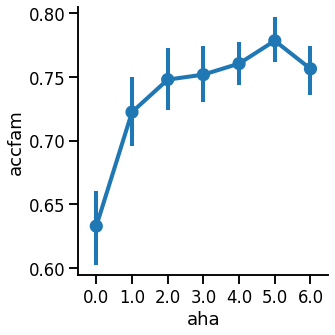

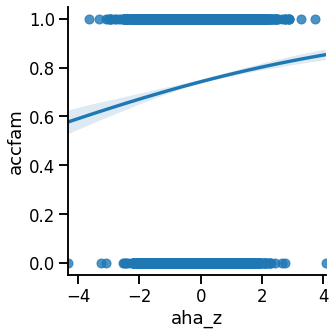

In [454]:
sns.catplot(x="aha", y="accfam",
            kind="point", data=dfp);
sns.lmplot(x="aha_z", y="accfam", data=dfp, logistic=True);

r, p = stats.pearsonr(dfp.aha_z, dfp.accfam)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Mildly.

In [440]:
# model formulation
fml = "accfam ~ aha_z * curiosity_z * confidence_z"

# covariance structure
ex = sm.cov_struct.Exchangeable()
#link fu
fa = sm.families.Binomial(sm.families.links.logit)

model = sm.GEE.from_formula(fml, "subject", dfp.dropna(), cov_struct=ex, family=fa)
result = model.fit()
print(result.summary())
print(result.cov_struct.summary())

                               GEE Regression Results                              
Dep. Variable:                      accfam   No. Observations:                 7551
Model:                                 GEE   No. clusters:                      211
Method:                        Generalized   Min. cluster size:                   5
                      Estimating Equations   Max. cluster size:                  66
Family:                           Binomial   Mean cluster size:                35.8
Dependence structure:         Exchangeable   Num. iterations:                     9
Date:                     Fri, 27 Mar 2020   Scale:                           1.000
Covariance type:                    robust   Time:                         18:13:10
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          2.0315     

## Does aha predict recognition memory?

pearson r = 0.102 p-value =  0.0


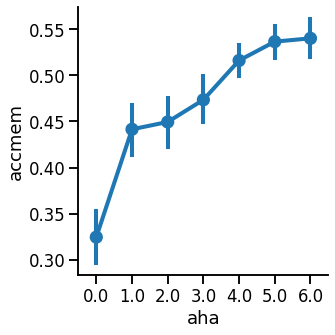

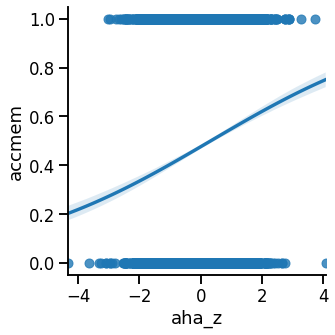

In [295]:

sns.catplot(x="aha", y="accmem",
            kind="point", data=dfp);
sns.lmplot(x="aha_z", y="accmem", data=dfp, logistic=True);

r, p = stats.pearsonr(dfp.dropna().aha_z, dfp.dropna().accmem)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Yes: more aha, better recognition memory. Note that this is acc==0 data only, acc does change the relation:

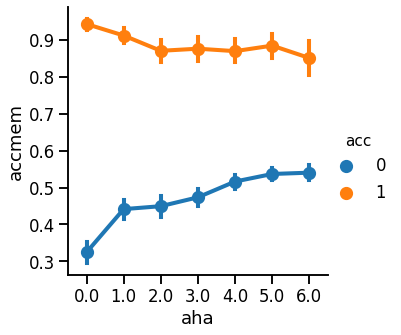

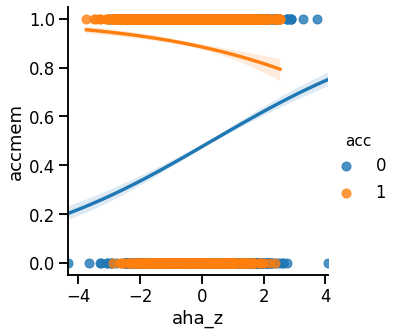

In [339]:

sns.catplot(x="aha", y="accmem",hue="acc",
            kind="point", data=dfo);
sns.lmplot(x="aha_z", y="accmem", hue="acc", data=dfo, logistic=True);


In [434]:
# model formulation
fml = "accmem ~ aha_z * acc"

# covariance structure
ex = sm.cov_struct.Exchangeable()
#link fu
fa = sm.families.Binomial(sm.families.links.logit)

model = sm.GEE.from_formula(fml, "subject", dfo, cov_struct=ex, family=fa)
result = model.fit()
print(result.summary())
print(result.cov_struct.summary())


                               GEE Regression Results                              
Dep. Variable:                      accmem   No. Observations:                16960
Model:                                 GEE   No. clusters:                      212
Method:                        Generalized   Min. cluster size:                  80
                      Estimating Equations   Max. cluster size:                  80
Family:                           Binomial   Mean cluster size:                80.0
Dependence structure:         Exchangeable   Num. iterations:                     9
Date:                     Fri, 27 Mar 2020   Scale:                           1.000
Covariance type:                    robust   Time:                         18:00:59
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0646      0.039     -1.646      0.100      -0.141       0.012
aha_z  

In [483]:
# model formulation
fml = "accmem ~ aha_z * curiosity_z * confidence_z * acc"

# covariance structure
ex = sm.cov_struct.Exchangeable()
#link fu
fa = sm.families.Binomial(sm.families.links.logit)

model = sm.GEE.from_formula(fml, "subject", dfo, cov_struct=ex, family=fa)
result = model.fit()
print(result.summary())
print(result.cov_struct.summary())


                               GEE Regression Results                              
Dep. Variable:                      accmem   No. Observations:                16880
Model:                                 GEE   No. clusters:                      211
Method:                        Generalized   Min. cluster size:                  80
                      Estimating Equations   Max. cluster size:                  80
Family:                           Binomial   Mean cluster size:                80.0
Dependence structure:         Exchangeable   Num. iterations:                    10
Date:                     Fri, 27 Mar 2020   Scale:                           1.000
Covariance type:                    robust   Time:                         20:03:54
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             

A model with every pre-reveal measure predicting recognition memory shows an effect of aha, of confidence, of acc, and an interaction between aha*acc. Notice that curiosity is not significant, but when aha is dropped from the model, it becomes strongly significant.

## Does curiosity (pre-reveal) predict recognition memory?

pearson r = 0.037 p-value =  0.001


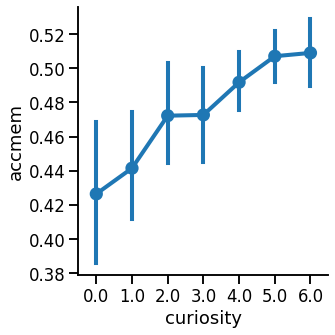

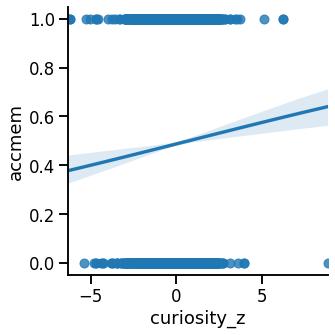

In [297]:
sns.catplot(x="curiosity", y="accmem",
            kind="point", data=dfp);
sns.lmplot(x="curiosity_z", y="accmem", data=dfp, logistic=True);

r, p = stats.pearsonr(dfp.dropna().curiosity_z, dfp.dropna().accmem)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Barely, but significantly. Unexpectedly low, given prior findings on relation between curiosity and memory. Maybe those findings (and ours) are mediated by aha, as the more important factor in memory.

## Does aha mediate the effect of curiosity on recognition memory?

TODO: not sure if this is the correct analysis for this. It is used in cases where there is a 'treatment effect' (vs control), to see whether this treatment effect is actually caused by a third (mediator) variable. ACME = average causal mediation effects; ADE = average direct effects. https://www.statsmodels.org/stable/generated/statsmodels.stats.mediation.Mediation.html

In [431]:
import statsmodels.genmod.families.links as links
from statsmodels.stats.mediation import Mediation
probit = links.probit
outcome_model = sm.GLM.from_formula("accmem ~ curiosity + aha",
                                    dfp, family=sm.families.Binomial(link=probit()))
mediator_model = sm.OLS.from_formula("aha ~ curiosity", dfp)
med = Mediation(outcome_model, mediator_model, "curiosity", "aha").fit()
med.summary()

Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.011220        0.009075        0.013586    0.000
ACME (treated)            0.011230        0.009087        0.013572    0.000
ADE (control)             0.002110       -0.003271        0.007614    0.466
ADE (treated)             0.002120       -0.003280        0.007649    0.466
Total effect              0.013341        0.008176        0.018765    0.000
Prop. mediated (control)  0.837721        0.574161        1.378365    0.000
Prop. mediated (treated)  0.838499        0.575783        1.377391    0.000
ACME (average)            0.011225        0.009078        0.013579    0.000
ADE (average)             0.002115       -0.003275        0.007632    0.466
Prop. mediated (average)  0.838110        0.574972        1.377881    0.000

## Does confidence predict recognition memory?

pearson r = -0.023 p-value =  0.046


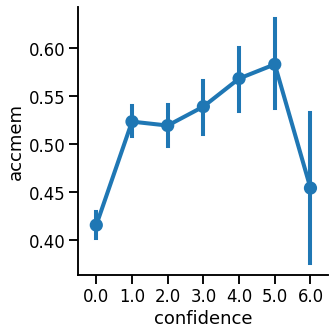

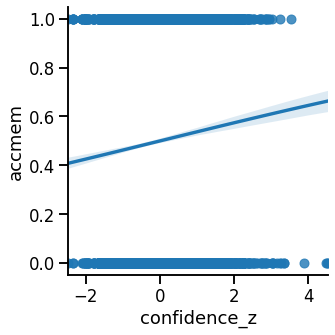

In [300]:
sns.catplot(x="confidence", y="accmem",
            kind="point", data=dfp);
sns.lmplot(x="confidence_z", y="accmem", data=dfp, logistic=True);

r, p = stats.pearsonr(dfp.confidence_z, dfp.accmem)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

No, but note a possible effect of the extremes on the confidence scale, suggestive of an inverted u-shape?

## Aha, confidence, curiosity rating distributions

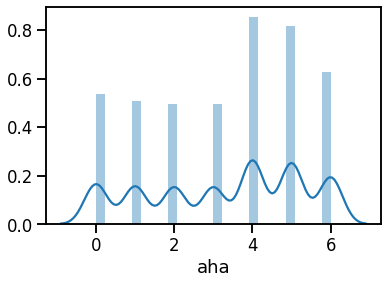

In [19]:
sns.distplot(df.aha.dropna())

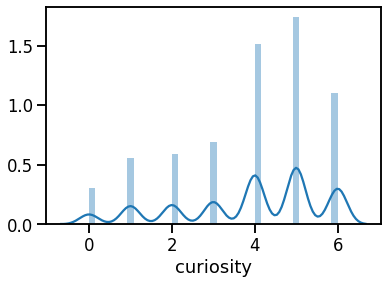

In [20]:
sns.distplot(df.curiosity.dropna())

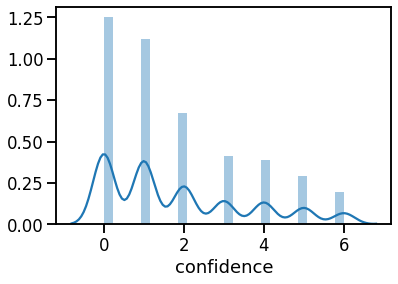

In [21]:
sns.distplot(df.confidence.dropna())

# Per subject analysis 

In [368]:

dfsubj = df[(df.old==1)].groupby(['subject']).agg(
    nbofobs=pd.NamedAgg(column='accfam', aggfunc='count'),
    countguess=pd.NamedAgg(column='guess', aggfunc='count'),
    countmem=pd.NamedAgg(column='guessmem', aggfunc='count'),
    accfamstd=pd.NamedAgg(column='accfam', aggfunc='std'),
    accstd=pd.NamedAgg(column='acc', aggfunc='std'),
    accmemstd=pd.NamedAgg(column='accmem', aggfunc='std'),
    confstd=pd.NamedAgg(column='confidence', aggfunc='std'),
    curstd=pd.NamedAgg(column='curiosity', aggfunc='std'),
    ahastd=pd.NamedAgg(column='aha', aggfunc='std')).reset_index()

dfsubj = dfsubj.merge(df[df.old==1].groupby('subject').mean().reset_index(), on='subject')

In [190]:
dfsubj.head()

subject  nbofobs  countguess  countmem  correctstd    accstd  accmemestd  \
0   00000       80          70        76    0.243589  0.428236    0.382364   
1   29689       80          71        72    0.346547  0.442769    0.461149   
2   34174       80          69        65    0.471330  0.435745    0.501737   
3   37525       80          75        57    0.428236  0.382364    0.500633   
4   37528       80          58        62    0.332805  0.382364    0.471330   

    confstd    curstd    ahastd  ...  perccur   NCS  AQ28  socskills  routine  \
0  1.583938  0.841093  1.229837  ...     35.0  34.0  82.0       23.0     12.0   
1  1.987142  0.584477  2.048116  ...     31.0  55.0  70.0       21.0     10.0   
2  2.098673  2.129918  2.439651  ...     23.0  32.0  77.0       19.0     10.0   
3  1.858099  1.828701  2.069023  ...     30.0  42.0  97.0       25.0     14.0   
4  1.649271  1.593053  1.902696  ...     38.0  52.0  89.0       22.0     11.0   

   switching  imagination  numbpatt     acc  accmem  
0       14.0         23.0      10.0  0.2375  0.8250  
1       14.0         13.0      12.0  0.2625  0.7000  
2       18.0         30.0       0.0  0.2500  0.5375  
3       20.0         20.0      18.0  0.1750  0.5500  
4       17.0         25.0      14.0  0.1750  0.6750  

[5 rows x 116 columns]

## Does a person's avg curiosity relate to his/her strength of aha or confidence?

pearson r = 0.564 p-value =  0.0


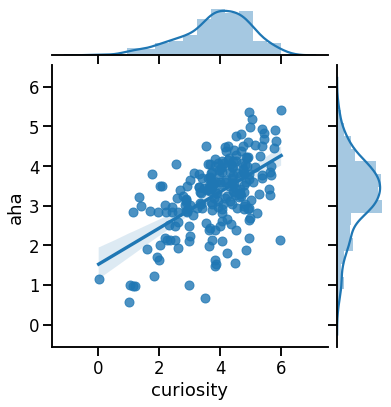

In [304]:
sns.jointplot(x="curiosity", y="aha", data=dfsubj, kind="reg");

r, p = stats.pearsonr(dfsubj.curiosity, dfsubj.aha)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

pearson r = -0.028 p-value =  0.687


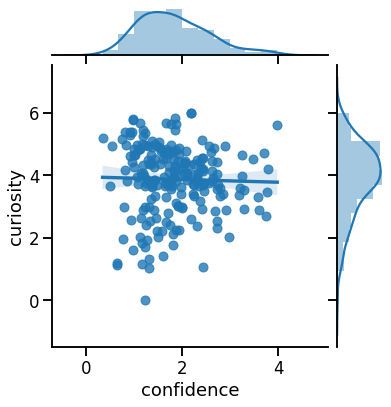

In [305]:
sns.jointplot(x="confidence", y="curiosity", data=dfsubj, kind="reg");
r, p = stats.pearsonr(dfsubj.confidence, dfsubj.curiosity)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

pearson r = 0.139 p-value =  0.043


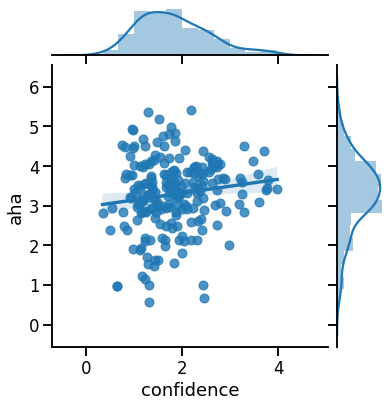

In [306]:
sns.jointplot(x="confidence", y="aha", data=dfsubj, kind="reg");
r, p = stats.pearsonr(dfsubj.confidence, dfsubj.aha)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

#### Conclusions

- Avg curiosity is positively related to a person's avg aha strength.
- No relation between confidence and curiosity on the person level
- A small, barely significant correlation between confidence and curiosity on person level.

## Person-level correlations with recognition memory

In [351]:
dfsubj = df[df.old==1].groupby(['subject', 'acc']).mean().reset_index()

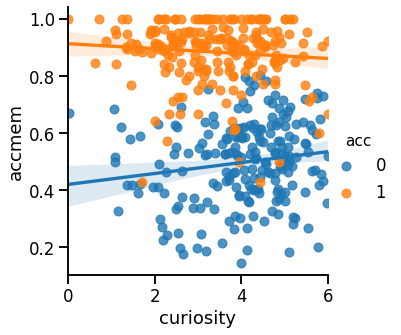

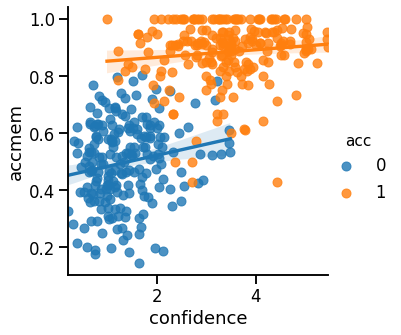

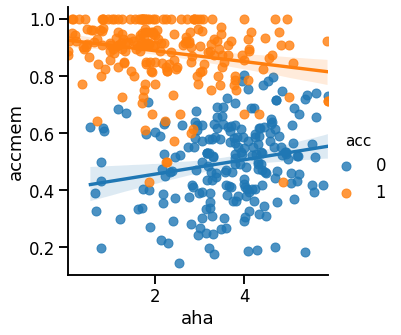

In [350]:
sns.lmplot(x="curiosity", y="accmem", hue="acc", data=dfsubj);
sns.lmplot(x="confidence", y="accmem", hue="acc", data=dfsubj);
sns.lmplot(x="aha", y="accmem",hue="acc", data=dfsubj);


## Does a person's avg curiosity relate to general curiosity measures (+ other traits from questionnaires)?

In [365]:
dfsubj = df[(df.old==1) & (df.acc==0)].groupby(['subject']).mean().reset_index()

fiveDCR pearson r = 0.201 p-value =  0.003
joyexp pearson r = 0.09 p-value =  0.193
deprsens pearson r = 0.141 p-value =  0.04
stresstol pearson r = -0.003 p-value =  0.967
ovsoccur pearson r = 0.249 p-value =  0.0
cosoccur pearson r = 0.194 p-value =  0.005
thrillseek pearson r = 0.001 p-value =  0.99
perccur pearson r = 0.255 p-value =  0.0
NCS pearson r = 0.008 p-value =  0.91
AQ28 pearson r = -0.042 p-value =  0.539
socskills pearson r = -0.01 p-value =  0.889
routine pearson r = -0.079 p-value =  0.253
switching pearson r = -0.084 p-value =  0.221
imagination pearson r = -0.074 p-value =  0.282
numbpatt pearson r = 0.106 p-value =  0.123


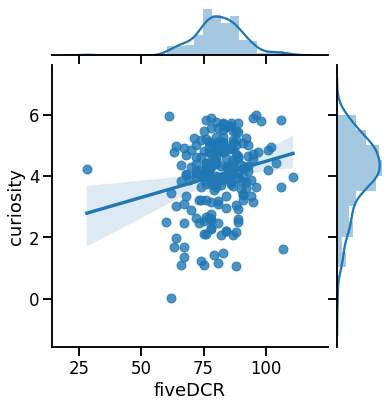

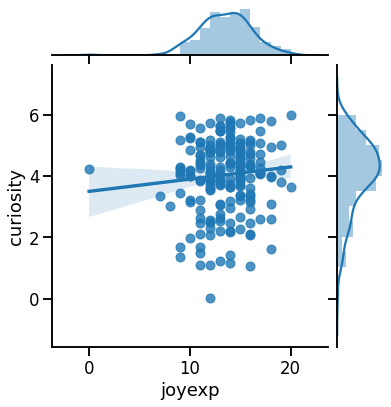

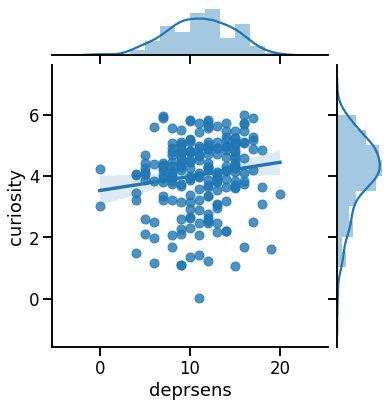

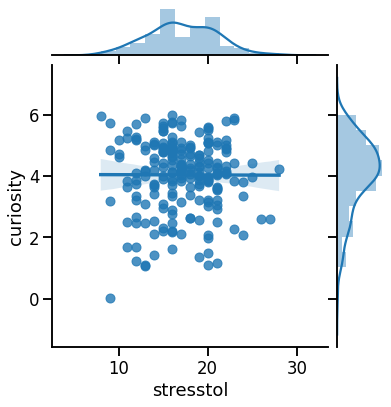

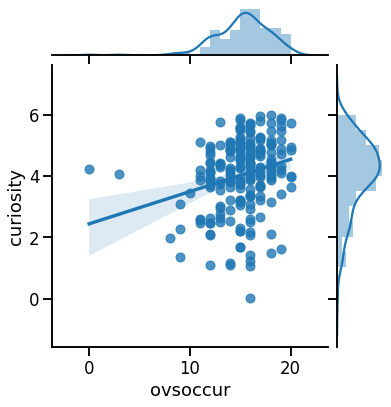

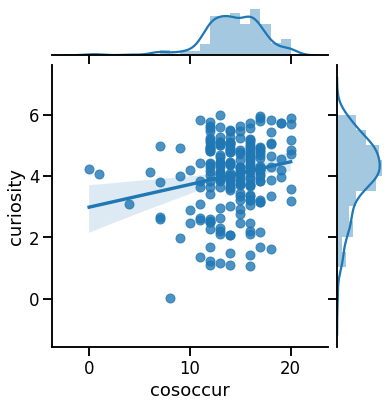

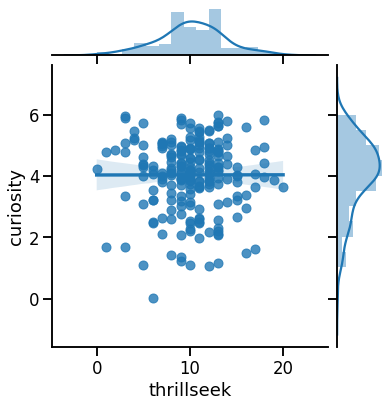

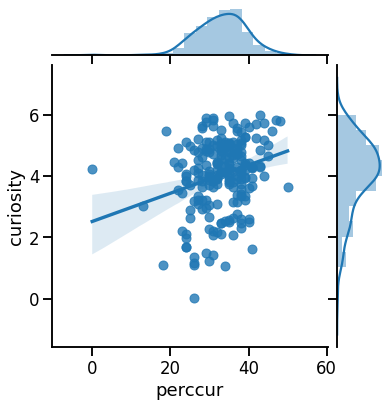

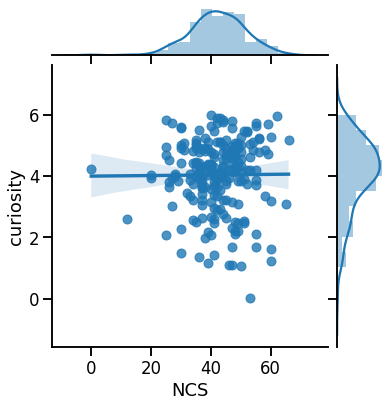

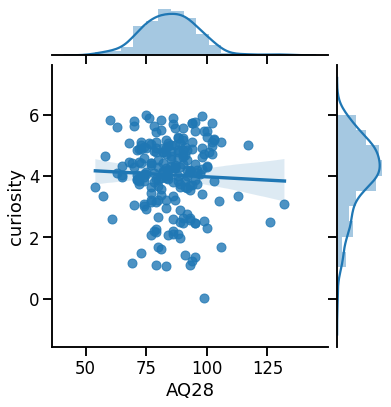

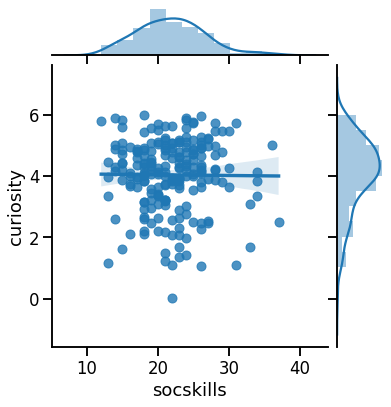

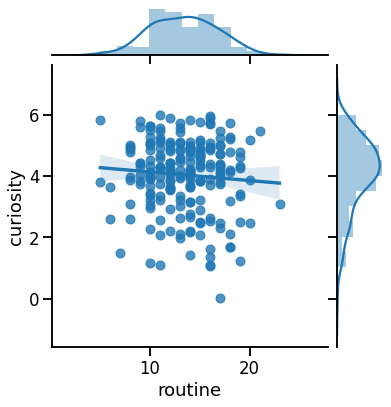

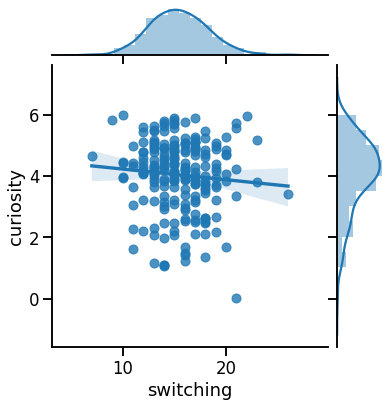

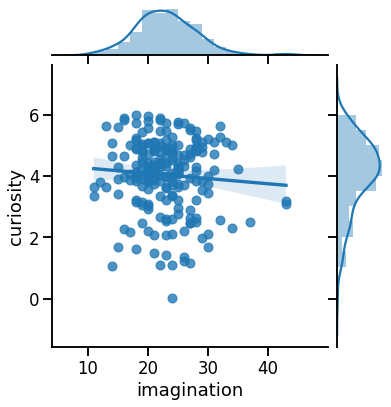

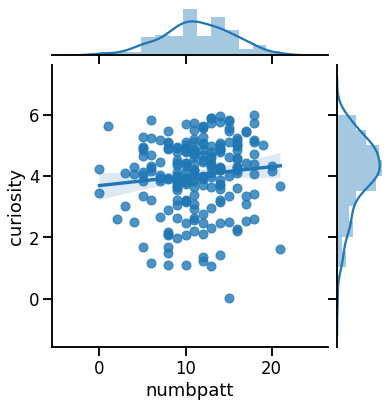

In [366]:
for quest in ['fiveDCR', 'joyexp', 'deprsens','stresstol','ovsoccur','cosoccur', 'thrillseek', 'perccur', 
              'NCS', 'AQ28', 'socskills','routine','switching', 'imagination', 'numbpatt']:
    
    r, p = stats.pearsonr(dfsubj.curiosity, dfsubj[quest])
    sns.jointplot(x=quest, y="curiosity", data=dfsubj, kind="reg");
    print(quest,'pearson r =', round(r,3), 'p-value = ', round(p,3))


#### Conclusions:

- Avg state curiosity in our task correlates positively, significantly with a conventional trait curiosity questionnaire (the 5-dimensional curiosity scale Revised; 5DCR)
- This correlation seems mostly caused by the correlation with the (overt) social curiosity subscale(s). However, correlations are rather small (meaning that our state curiosity is not well-captured by the trait curiosity measures).
- The 5DCR does not include a sensory curiosity subscale. Hence, we added one (Perceptual curiosity scale), and, as expected trait perceptual curiosity significantly correlates with avg state curiosity in our task.
- Notably, the autism questionnaire nor the need for closure scale correlates with avg state curiosity. Interestingly (see matrix below), AQ28 is strongly negatively related to trait curiosity (5DCR), suggesting either that trait curiosity (but not state curiosity as measured in our task) is lower in people with more ASD-like traits, and/or that trait curiosity as measured by the 5DCR is too much focused on social curiosity (however note that trait perceptual curiosity is also somewhat negatively related with AQ28).

## Make a correlation matrix with questionnaires

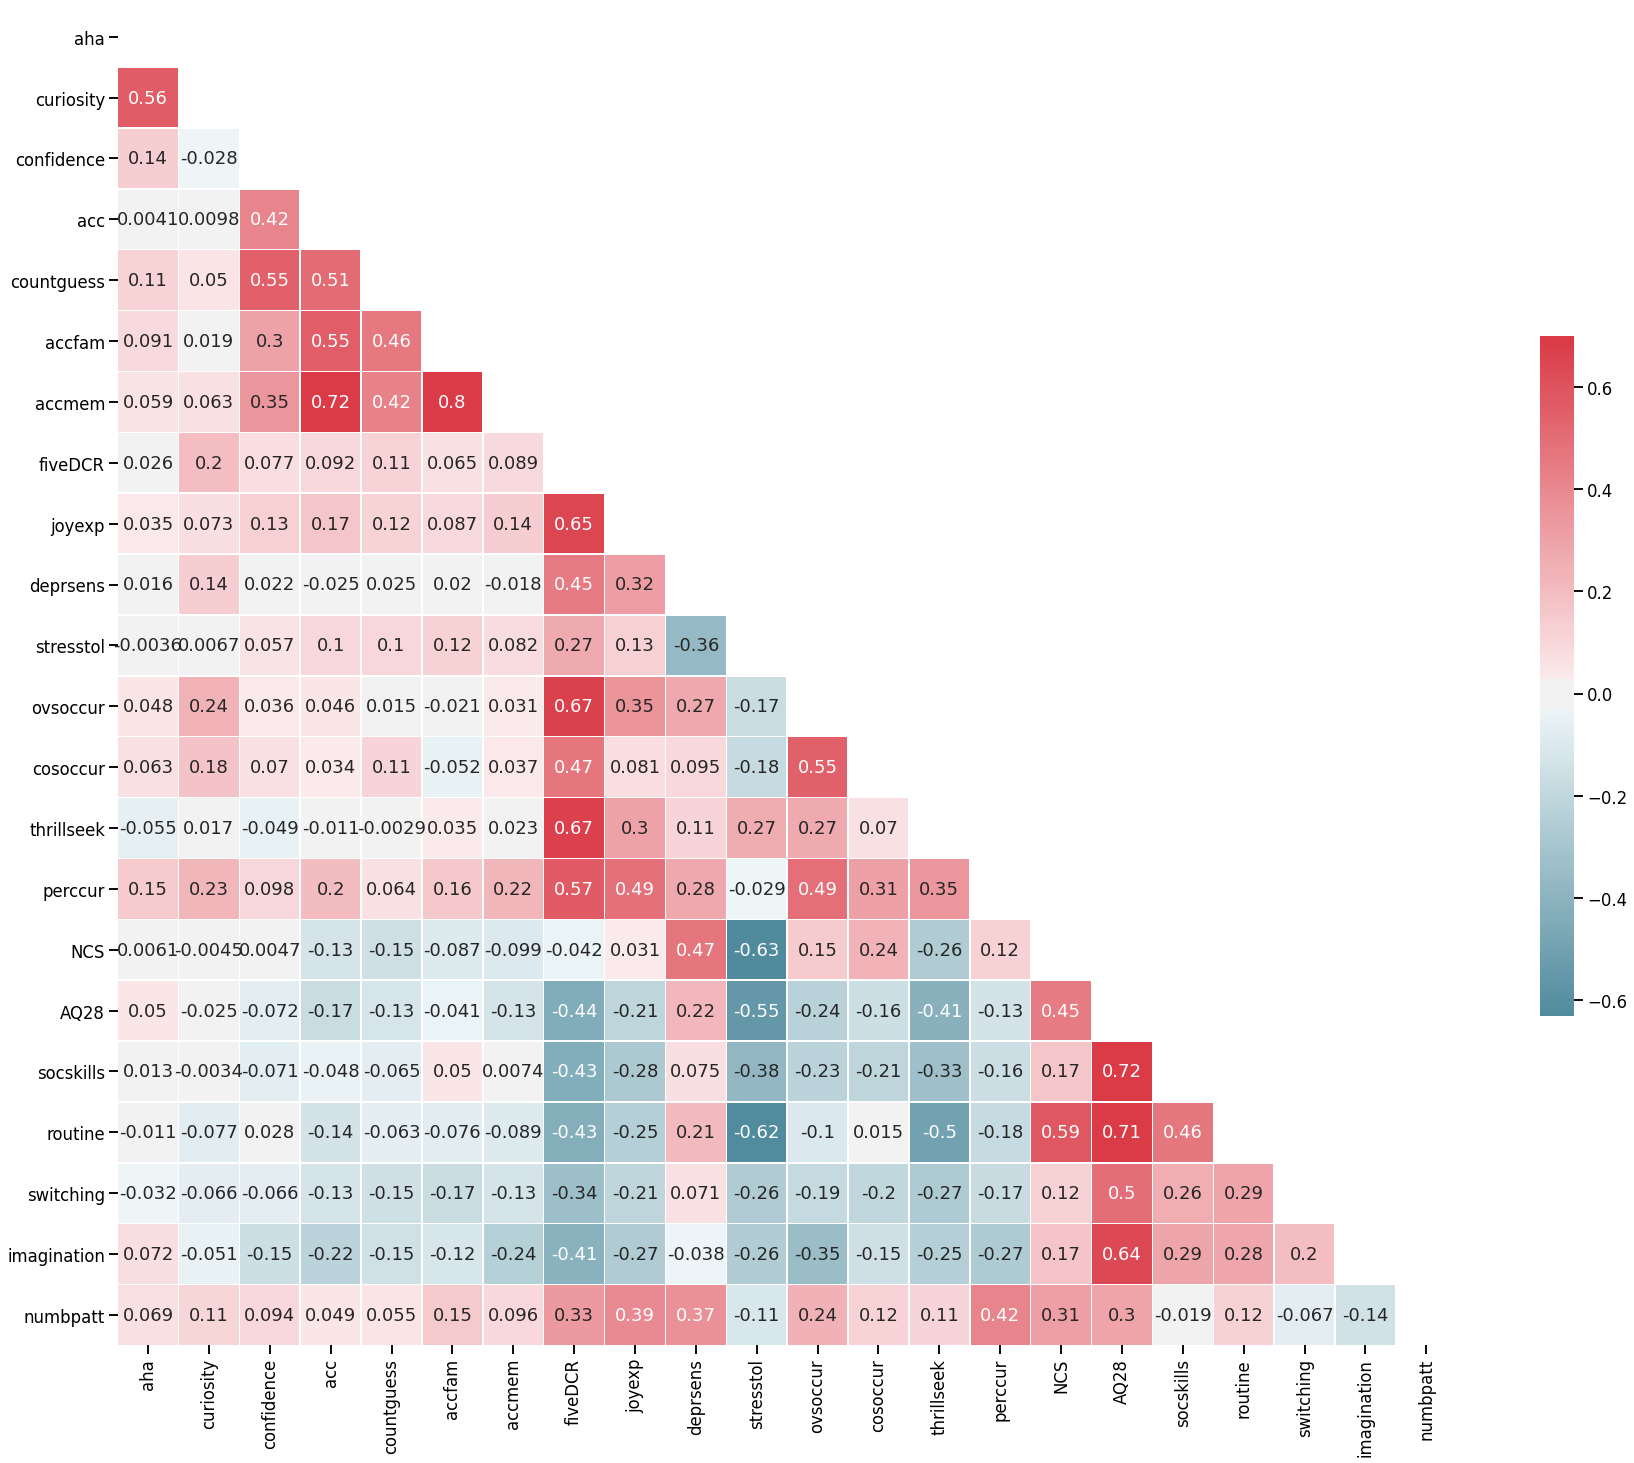

In [359]:
# Compute the correlation matrix
corr = dfsubj[['aha','curiosity', 'confidence', 'acc', 'countguess', 'accfam', 'accmem','fiveDCR', 'joyexp', 'deprsens','stresstol','ovsoccur','cosoccur', 'thrillseek', 'perccur', 
              'NCS', 'AQ28', 'socskills','routine','switching', 'imagination', 'numbpatt']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 25))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,
            square=True, linewidths=.5, annot= True, cbar_kws={"shrink": .5});

#### Other things of note:
- The correlations between perceptual curiosity and pre-reveal accuracy or recognition memory may be interesting
- Similar with negative correlations between imagination subscale of the AQ28 and pre-reveal accuracy or recognition memory. Note that high imagination score means more autism-like imagination, so lower actual imagination. Could point to the relevance of one's top-down generative capacity to come up with possible solutions.
- Relatedly, some (low: .15) negative correlations are present between the number of guesses (countguess; irrespective of acc) and imagination/NCS (significant but won't survive correction if needed; cf. planned)

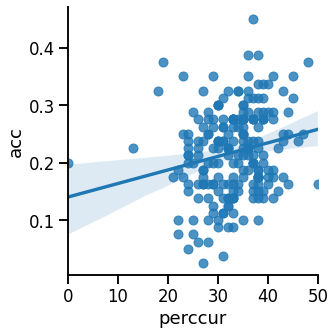

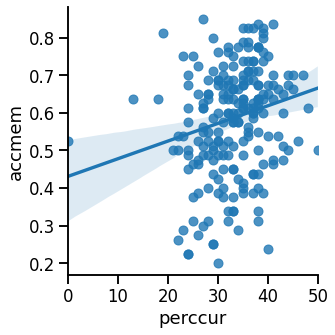

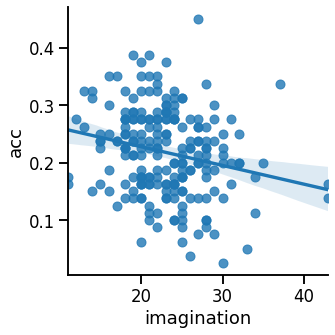

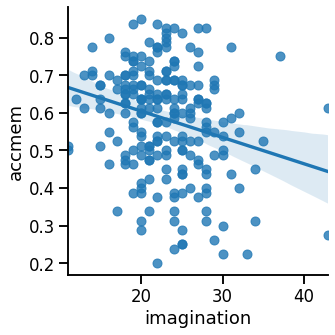

In [369]:
sns.lmplot(x='perccur', y="acc", data=dfsubj, robust=True);
sns.lmplot(x='perccur', y="accmem", data=dfsubj, robust=True);
sns.lmplot(x='imagination', y="acc", data=dfsubj, robust=True);
sns.lmplot(x='imagination', y="accmem", data=dfsubj, robust=True);

## TODO: Relating familiarity d primes to avg curiosity, conf, aha, questionnaires

In [331]:
df.groupby(['subject','old']).accfam.mean() 


subject  old
00000    0      0.7500
         1      0.9375
29689    0      1.0000
         1      0.8625
34174    0      0.9500
                 ...  
40294    1      0.7875
CA       0      1.0000
         1      0.9625
MJ       0      0.8500
         1      0.7750
Name: correct, Length: 424, dtype: float64

# Per image analysis

In [422]:
dfim = df[(df.old==1)].groupby(['currentStim']).agg(
    nbofobs=pd.NamedAgg(column='accfam', aggfunc='count'),
    accfam=pd.NamedAgg(column='accfam', aggfunc='mean'),
    countguess=pd.NamedAgg(column='guess', aggfunc='count'),
    countmem=pd.NamedAgg(column='guessmem', aggfunc='count'),
    accfamstd=pd.NamedAgg(column='accfam', aggfunc='std'),
    #acc=pd.NamedAgg(column='acc', aggfunc='mean'),
    #accstd=pd.NamedAgg(column='acc', aggfunc='std'),
    accmem=pd.NamedAgg(column='accmem', aggfunc='mean'),
    accmemstd=pd.NamedAgg(column='accmem', aggfunc='std'),
    confidence=pd.NamedAgg(column='confidence', aggfunc='mean'),
    confstd=pd.NamedAgg(column='confidence', aggfunc='std'),
    curiosity=pd.NamedAgg(column='curiosity', aggfunc='mean'),
    curstd=pd.NamedAgg(column='curiosity', aggfunc='std'),
    aha=pd.NamedAgg(column='aha', aggfunc='mean'),
    ahastd=pd.NamedAgg(column='aha', aggfunc='std')).reset_index()

In [317]:
#nb of observations per image
dfim.nbofobs.mean()

65.30541871921183

Make new var for percentage of people that have made a guess for a given image

In [423]:
dfim['percguess'] = dfim.countguess/dfim.nbofobs
dfim['percmemguess'] = dfim.countmem/dfim.nbofobs
dfim.head()

currentStim  nbofobs    accfam  countguess  countmem  accfamstd  \
0  ../img/tt/001tt.jpg       67  0.626866          49        49   0.487288   
1  ../img/tt/007tt.jpg       70  0.800000          44        60   0.402888   
2  ../img/tt/008tt.jpg       50  0.900000          34        39   0.303046   
3  ../img/tt/010tt.jpg      102  0.852941          62        62   0.355914   
4  ../img/tt/013tt.jpg       77  0.480519          33        42   0.502897   

     accmem  accmemstd  confidence   confstd  curiosity    curstd       aha  \
0  0.462687   0.502369    1.253731  1.295017   4.238806  1.508456  3.268657   
1  0.685714   0.467583    1.128571  1.371780   4.342857  1.640835  3.357143   
2  0.700000   0.462910    1.160000  1.447870   4.160000  1.694649  3.700000   
3  0.323529   0.470133    0.833333  1.090765   4.039216  1.676403  3.156863   
4  0.350649   0.480302    0.545455  1.118569   4.311688  1.672217  4.376623   

     ahastd  percguess  percmemguess  
0  1.942991   0.731343      0.731343  
1  2.029034   0.628571      0.857143  
2  1.631951   0.680000      0.780000  
3  2.071710   0.607843      0.607843  
4  1.701694   0.428571      0.545455

## Does avg curiosity of image relate to its avg aha strength or confidence?

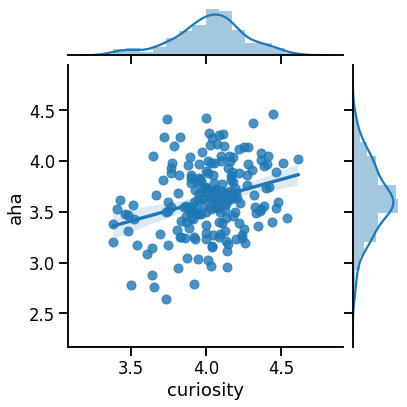

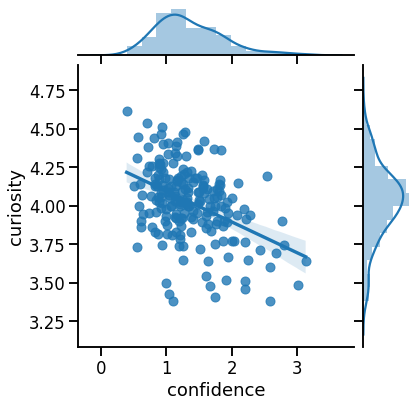

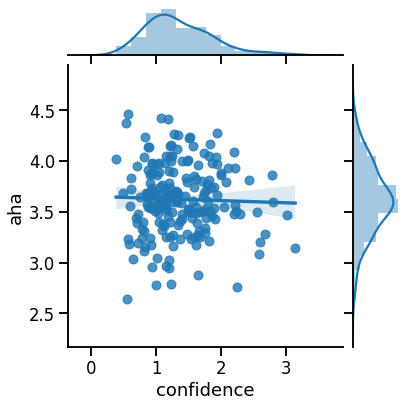

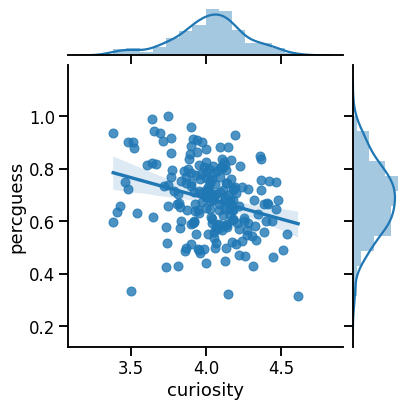

In [379]:
sns.jointplot(x="curiosity", y="aha", data=dfim, kind="reg");
sns.jointplot(x="confidence", y="curiosity", data=dfim, kind="reg");
sns.jointplot(x="confidence", y="aha", data=dfim, kind="reg");
sns.jointplot(x="curiosity", y="percguess", data=dfim, kind="reg");

- Avg img curiosity is strongly positively related to avg im aha strength.
- Avg img confidence is strongly negatively related to avg im curiosity.
- No link between image confidence and image aha.
- Higher curiosity of the image means lower percentage of people have made a guess

## Does higher image aha mean higher image recognition memory?

pearson r = 0.287 p-value =  0.0


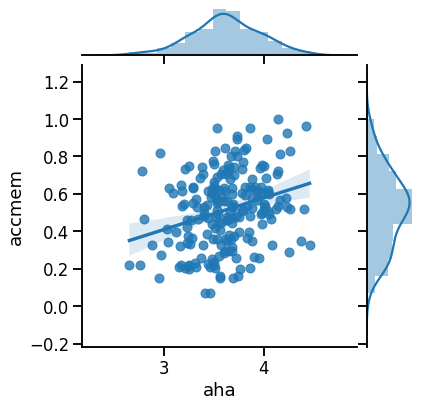

In [376]:
sns.jointplot(x="aha", y="accmem", data=dfim, kind="reg");

r, p = stats.pearsonr(dfim.aha, dfim.accmem)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))


Yes, it does.

## Make column to merge complexity measures on

In [424]:
dfim['imgName'] = dfim.currentStim.str.extract('(\d+)')
dfim['imgName'] = dfim['imgName'].astype(int)

In [30]:
dfim.head()

currentStim   correct  correctstd      conf   confstd       cur  \
0  ../img/tt/001tt.jpg  0.707071    0.457422  1.415584  1.489884  4.142857   
1  ../img/tt/007tt.jpg  0.833333    0.374415  1.559524  1.731015  4.261905   
2  ../img/tt/008tt.jpg  0.884211    0.321670  1.333333  1.433994  4.055556   
3  ../img/tt/010tt.jpg  0.871795    0.335756  0.834951  1.085529  4.048544   
4  ../img/tt/013tt.jpg  0.614035    0.488972  1.021739  1.663957  4.065217   

     curstd       aha    ahastd  imgName  
0  1.545062  3.220779  1.930526        1  
1  1.591537  3.119048  2.130698        7  
2  1.652049  3.583333  1.633712        8  
3  1.670850  3.174757  2.069513       10  
4  1.808432  3.891304  2.018903       13

## Read in complexity measures

In [381]:
dfc = pd.read_csv('../complexity_measures/mooneyFeatures.csv')

In [28]:
dfc.head()

imgName  entropyMooney  entropyGrayscale  structSim  selfSimilarityMooney  \
0        1       1.756312          7.350505   0.354134               0.52439   
1        7       3.046183          7.834113   0.176417               0.65547   
2        8       2.098715          7.739233   0.304084               0.51810   
3        9       1.867433          7.753575   0.336164               0.44506   
4       10       1.597833          5.565031   0.090799               0.41812   

   selfSimilarityGrayscale  PHOGcomplexityMooney  PHOGcomplexityGrayscale  \
0                  0.56992                6.2874                  21.0880   
1                  0.67581               10.7960                  14.3860   
2                  0.53891                9.2955                  11.0410   
3                  0.44753                7.3215                   4.3294   
4                  0.54948                6.2084                   7.2984   

   anisotropyMooney  anisotropyGrayscale  edgeEntropyMooney  \
0          0.001429             0.001260           0.182302   
1          0.000691             0.000292           0.259272   
2          0.001570             0.000695           0.221323   
3          0.001745             0.001266           0.193137   
4          0.001604             0.000822           0.183774   

   edgeEntropyGrayscale  
0              0.573023  
1              0.565986  
2              0.407314  
3              0.271203  
4              0.478438

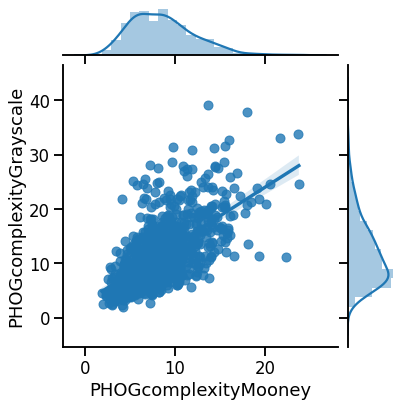

In [382]:
sns.jointplot(x="PHOGcomplexityMooney", y="PHOGcomplexityGrayscale", data=dfc, kind="reg");

In [383]:
r, p = stats.pearsonr(dfc.PHOGcomplexityMooney, dfc.PHOGcomplexityGrayscale)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

pearson r = 0.621 p-value =  0.0


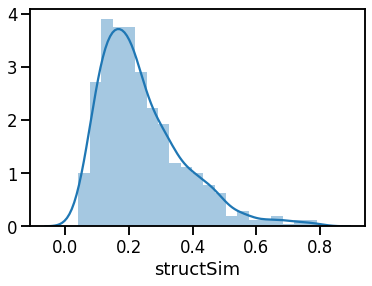

In [384]:
sns.distplot(dfc.structSim)

## Merge data of pretest and complexity measures

In [425]:
dfim= pd.merge(dfim, dfc, how='left', on='imgName')
dfim.head()

currentStim  nbofobs    accfam  countguess  countmem  accfamstd  \
0  ../img/tt/001tt.jpg       67  0.626866          49        49   0.487288   
1  ../img/tt/007tt.jpg       70  0.800000          44        60   0.402888   
2  ../img/tt/008tt.jpg       50  0.900000          34        39   0.303046   
3  ../img/tt/010tt.jpg      102  0.852941          62        62   0.355914   
4  ../img/tt/013tt.jpg       77  0.480519          33        42   0.502897   

     accmem  accmemstd  confidence   confstd  ...  entropyGrayscale  \
0  0.462687   0.502369    1.253731  1.295017  ...          7.350505   
1  0.685714   0.467583    1.128571  1.371780  ...          7.834113   
2  0.700000   0.462910    1.160000  1.447870  ...          7.739233   
3  0.323529   0.470133    0.833333  1.090765  ...          5.565031   
4  0.350649   0.480302    0.545455  1.118569  ...          7.754878   

   structSim  selfSimilarityMooney  selfSimilarityGrayscale  \
0   0.354134               0.52439                  0.56992   
1   0.176417               0.65547                  0.67581   
2   0.304084               0.51810                  0.53891   
3   0.090799               0.41812                  0.54948   
4   0.302509               0.57103                  0.73293   

   PHOGcomplexityMooney  PHOGcomplexityGrayscale  anisotropyMooney  \
0                6.2874                  21.0880          0.001429   
1               10.7960                  14.3860          0.000691   
2                9.2955                  11.0410          0.001570   
3                6.2084                   7.2984          0.001604   
4                8.3549                  12.2840          0.001264   

   anisotropyGrayscale  edgeEntropyMooney  edgeEntropyGrayscale  
0             0.001260           0.182302              0.573023  
1             0.000292           0.259272              0.565986  
2             0.000695           0.221323              0.407314  
3             0.000822           0.183774              0.478438  
4             0.000585           0.212878              0.516667  

[5 rows x 28 columns]

## Is there a correlation between structural similarity (mooney and grayscale) and recognition/familiarity/memory?

pearson r = -0.007 p-value =  0.926


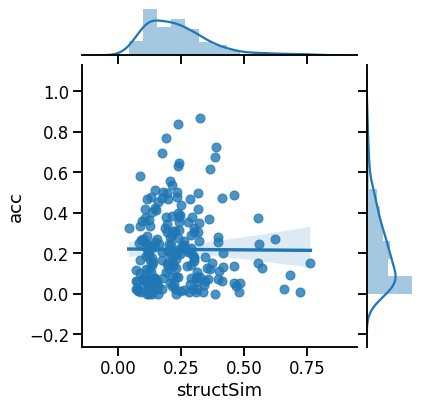

In [395]:
sns.jointplot(x="structSim", y="acc", data=dfim, kind="reg");

r, p = stats.pearsonr(dfim.structSim, dfim.acc)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

pearson r = 0.184 p-value =  0.008


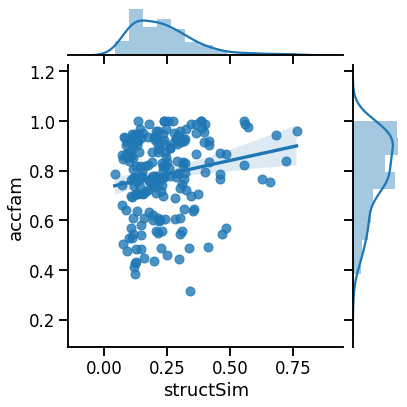

In [396]:
sns.jointplot(x="structSim", y="accfam", data=dfim, kind="reg");

r, p = stats.pearsonr(dfim.structSim, dfim.accfam)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

pearson r = 0.141 p-value =  0.044


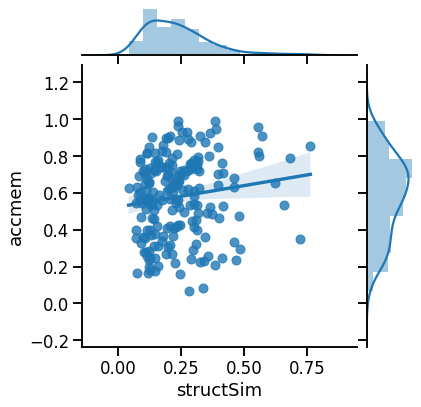

In [397]:
sns.jointplot(x="structSim", y="accmem", data=dfim, kind="reg");

r, p = stats.pearsonr(dfim.structSim, dfim.accmem)
print('pearson r =', round(r,3), 'p-value = ', round(p,3))

Struct sim does relate positively (though only mildly) with post-reveal familiarity and recognition memory.

## Does struct sim predict confidence, curiosity, aha?

aha: pearson r = -0.065 p-value =  0.194
curiosity: pearson r = -0.117 p-value =  0.019
confidence: pearson r = 0.072 p-value =  0.152


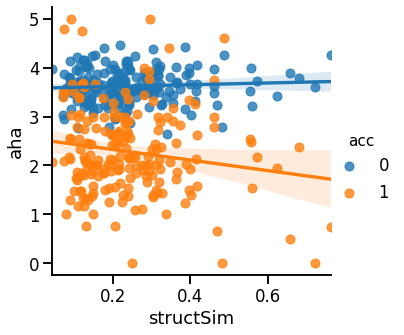

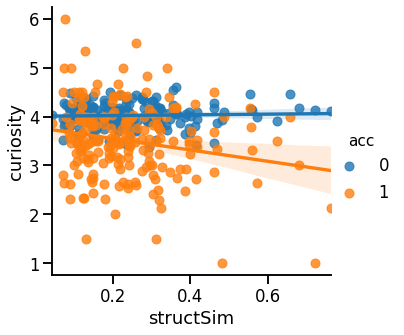

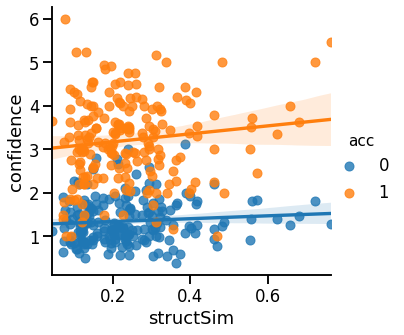

In [410]:
sns.lmplot(x="structSim", y="aha", hue='acc', data=dfim);
sns.lmplot(x="structSim", y="curiosity", hue='acc', data=dfim);
sns.lmplot(x="structSim", y="confidence", hue='acc', data=dfim);
r, p = stats.pearsonr(dfim.structSim, dfim.aha)
print('aha: pearson r =', round(r,3), 'p-value = ', round(p,3))
r, p = stats.pearsonr(dfim.structSim, dfim.curiosity)
print('curiosity: pearson r =', round(r,3), 'p-value = ', round(p,3))
r, p = stats.pearsonr(dfim.structSim, dfim.confidence)
print('confidence: pearson r =', round(r,3), 'p-value = ', round(p,3))

Nope. To test: if image was accurately identified, higher struct sim means lower curiosity/aha (makes sense, captures the obviousness of the content in the Mooney?).

## Make correlation matrix

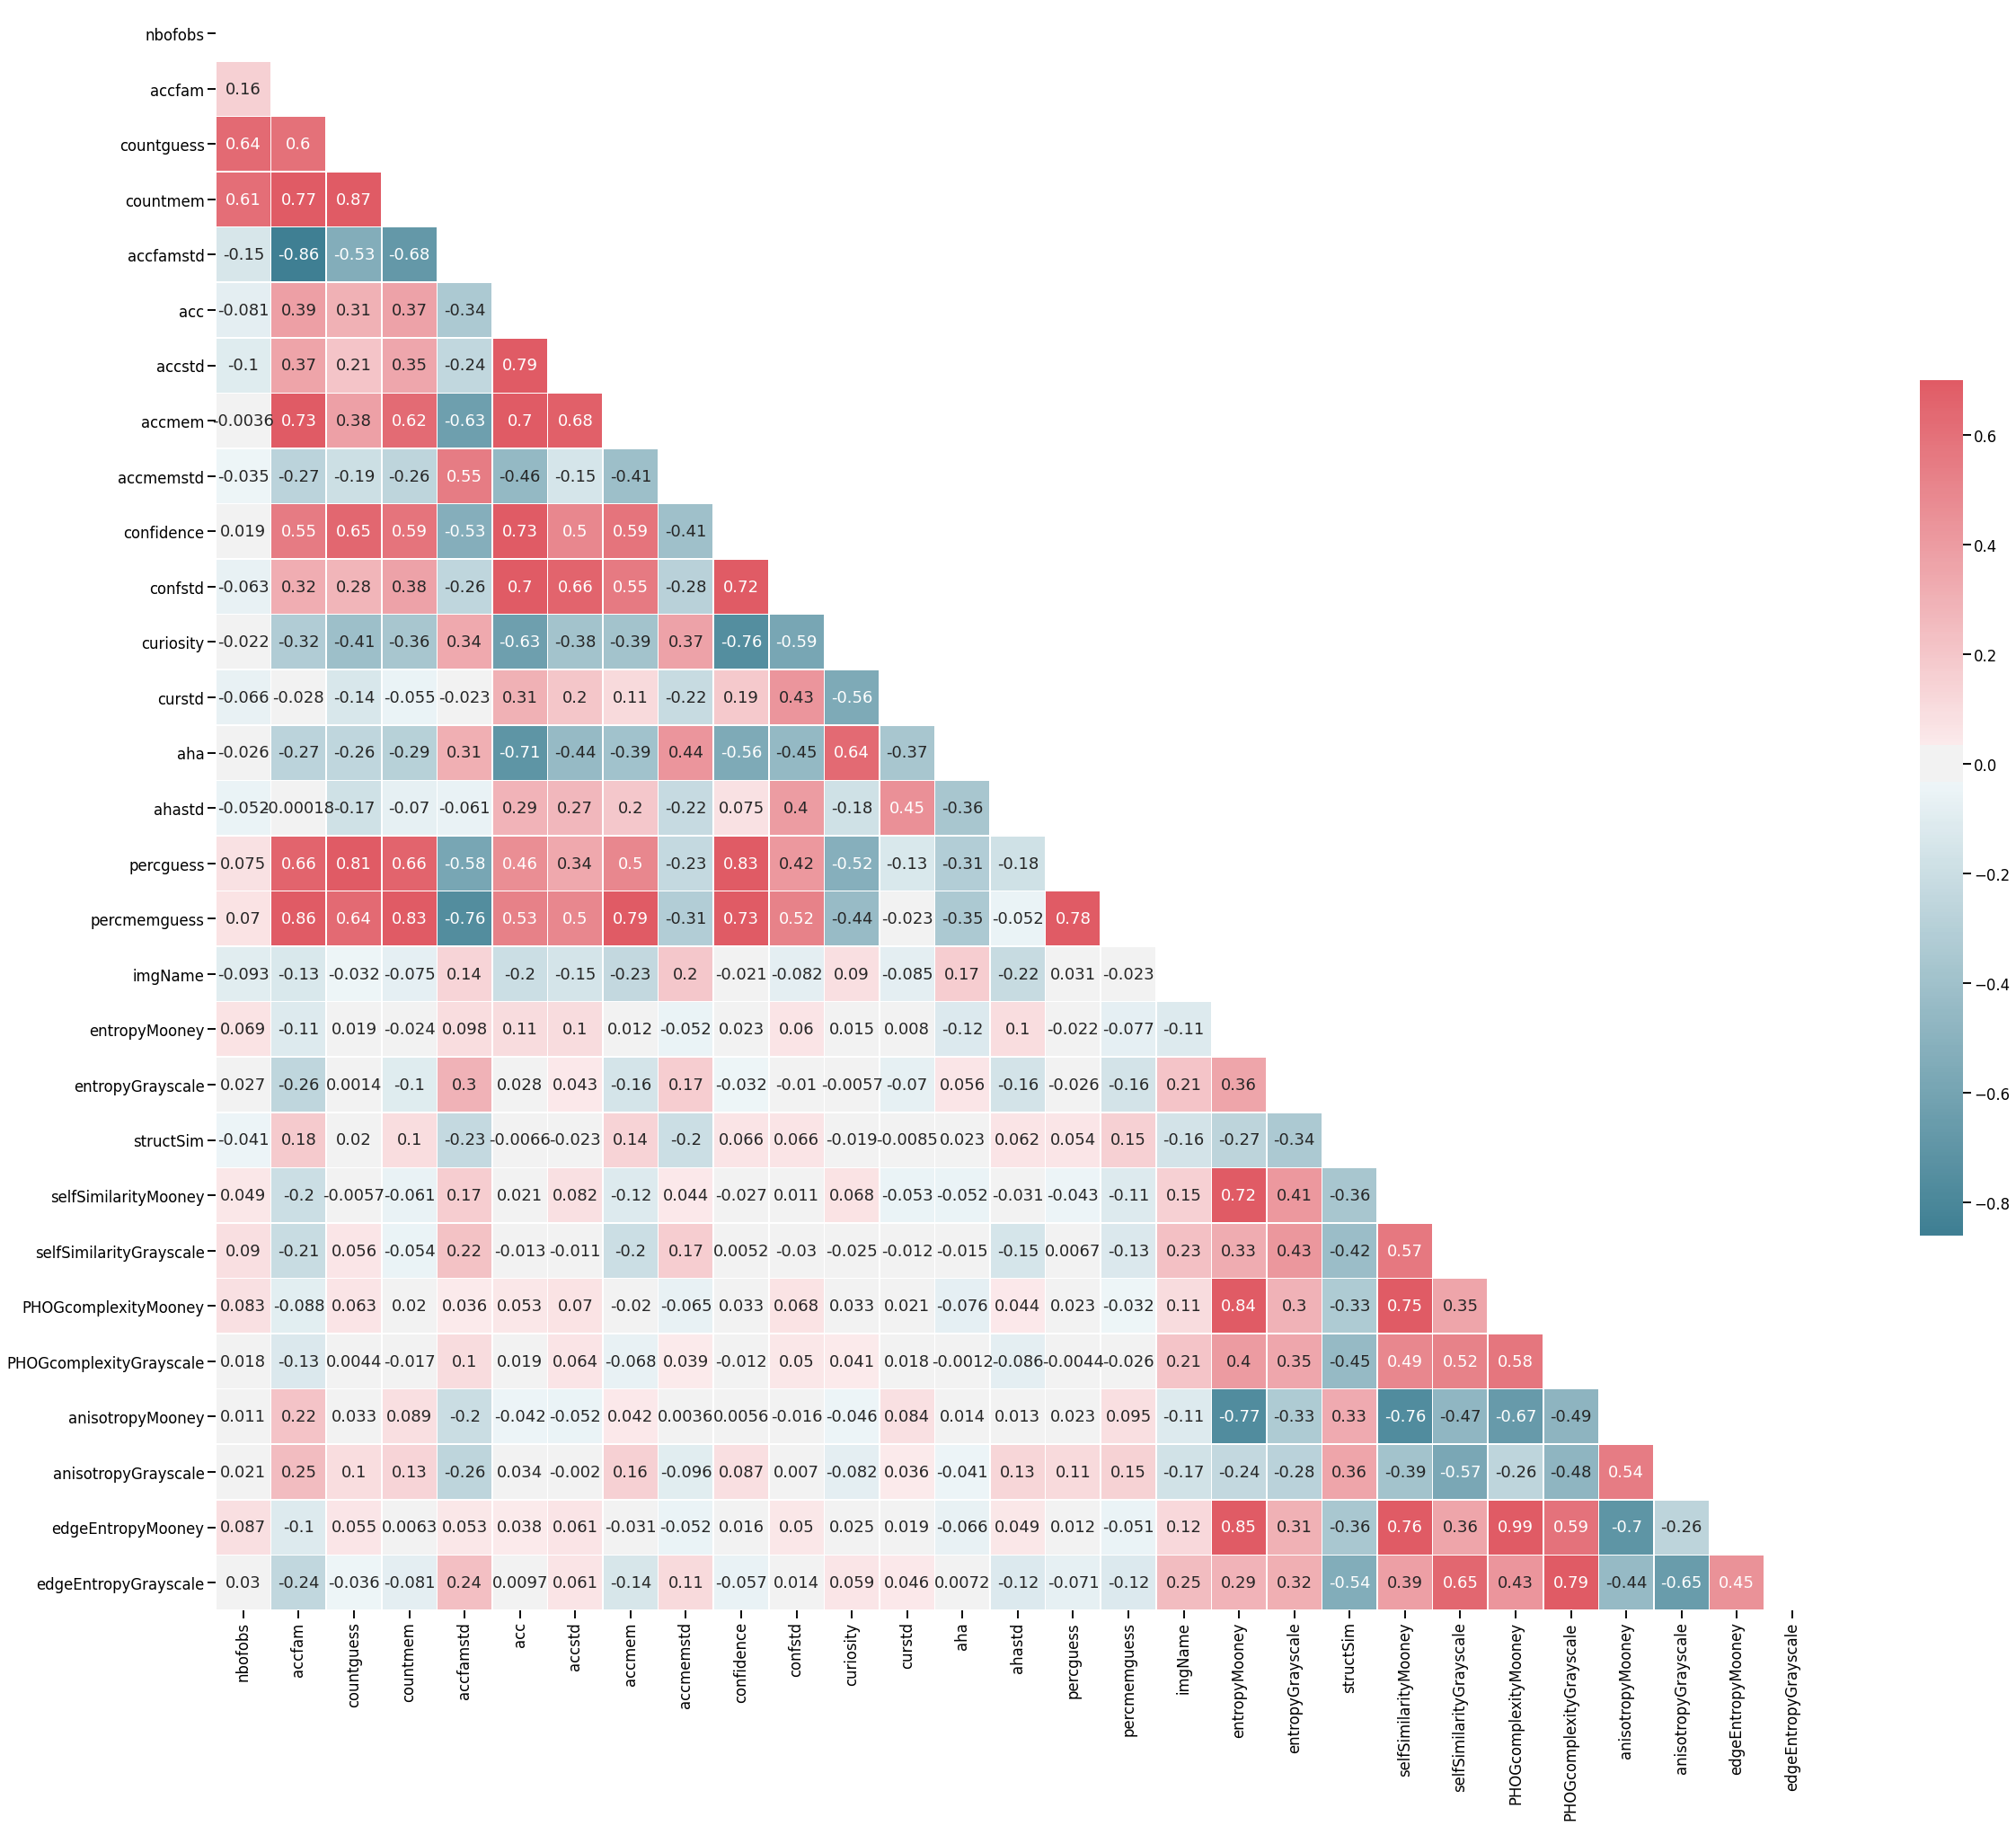

In [401]:
# Compute the correlation matrix
corr = dfim.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(40, 35))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,
            square=True, linewidths=.5, annot= True, cbar_kws={"shrink": .5});

Other things to note:
- Mooney familiarity (accfam) seems to be related to several complexity measures (>.2)
- A subset of those also correlate with recognition memory (though usually less so: .12-.2).
- Anisotropy and self-similarity seem to be dominant here (why?)
- Remains to be seen how much of this survives corrected alpha level. For example (10 complexity measures: alpha= .05/10=.005), selfsim with accmem would be significant, while anisotropy would not (see below). Roughly, it seems a correlation of around .20 is needed to be significant.
- I think we can argue that we had an hypothesis about struct sim and recognition memory (so this can be uncorrected), but not for all other (single image) complexity measures.


selfSimilarityGrayscale: pearson r = -0.238 p-value =  0.001
anisotropyGrayscale: pearson r = 0.183 p-value =  0.009


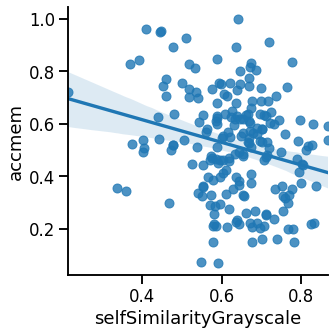

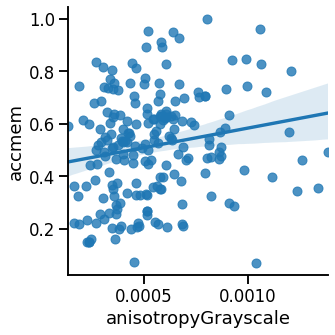

In [426]:
sns.lmplot(x="selfSimilarityGrayscale", y="accmem", data=dfim);
r, p = stats.pearsonr(dfim.selfSimilarityGrayscale, dfim.accmem)
print('selfSimilarityGrayscale: pearson r =', round(r,3), 'p-value = ', round(p,3))

sns.lmplot(x="anisotropyGrayscale", y="accmem", data=dfim);
r, p = stats.pearsonr(dfim.anisotropyGrayscale, dfim.accmem)
print('anisotropyGrayscale: pearson r =', round(r,3), 'p-value = ', round(p,3))

## Distribution of the (complexity) measures?

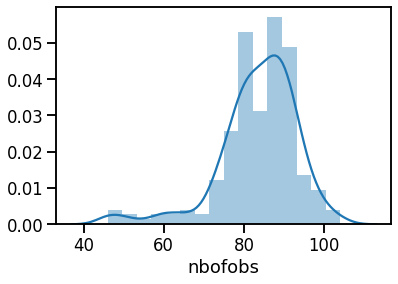

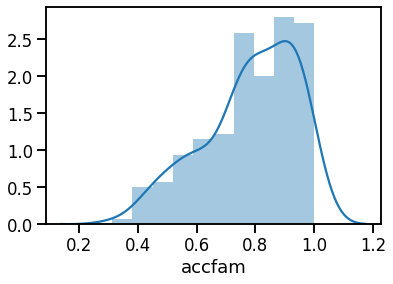

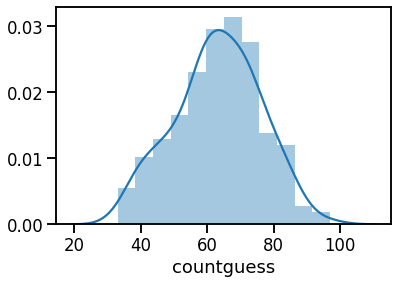

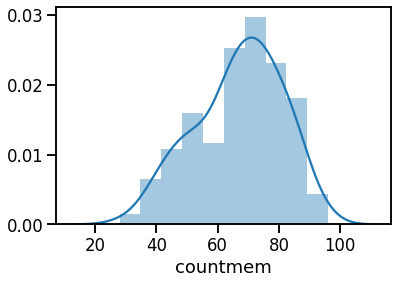

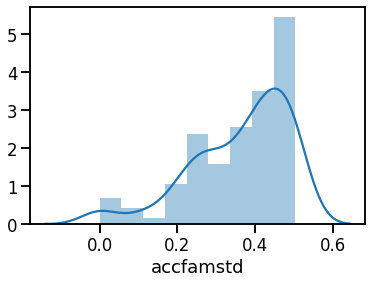

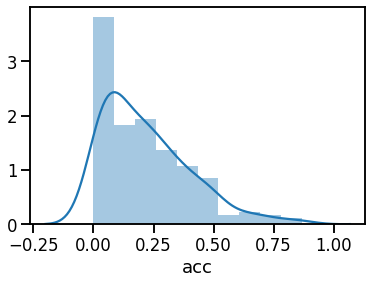

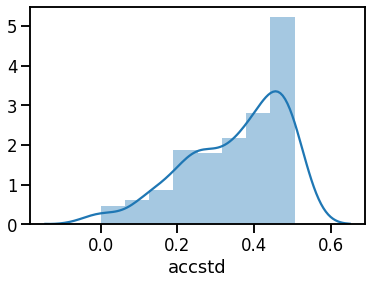

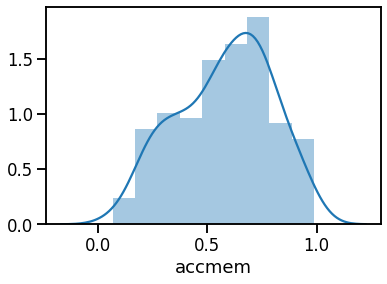

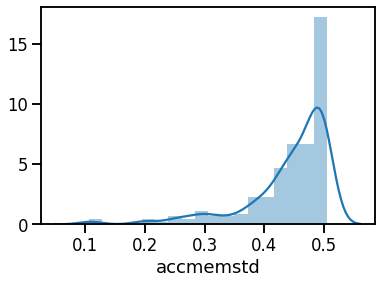

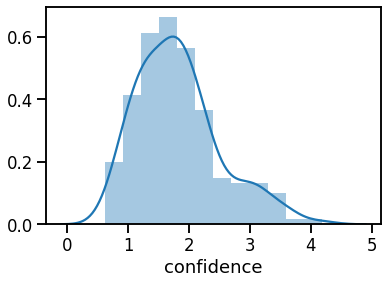

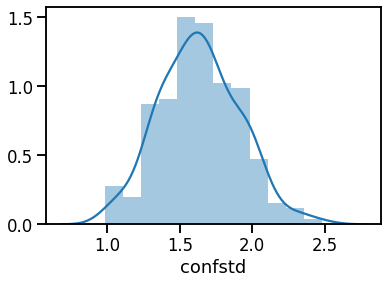

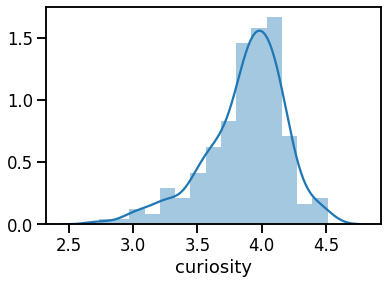

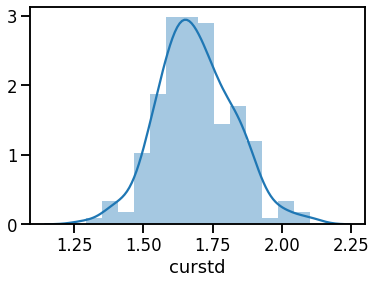

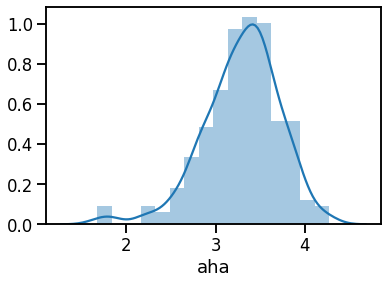

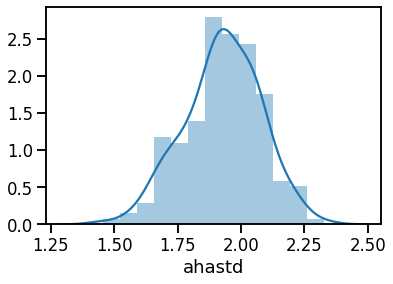

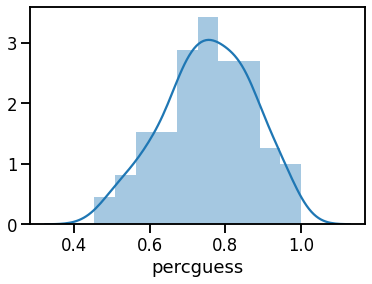

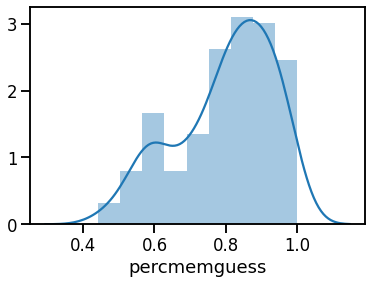

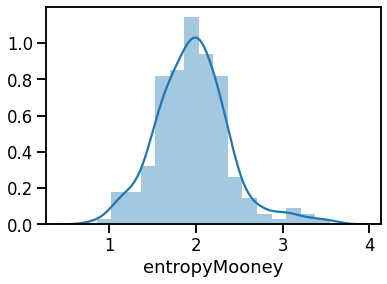

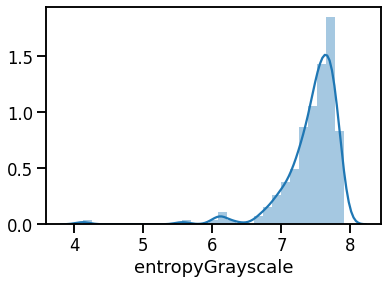

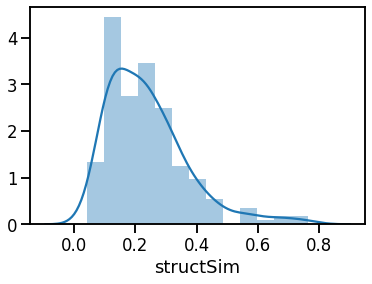

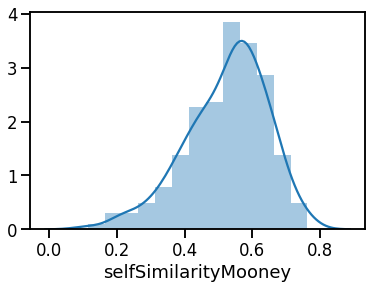

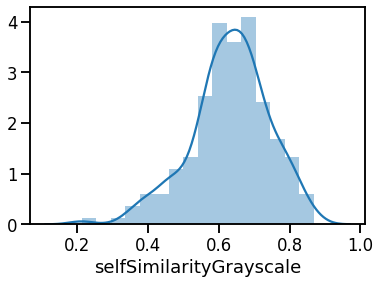

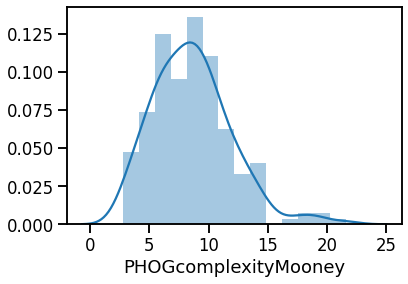

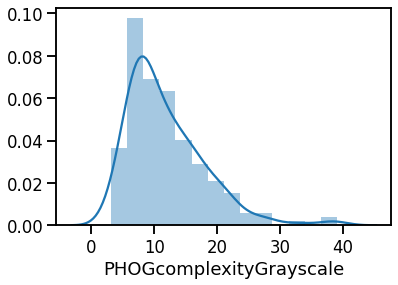

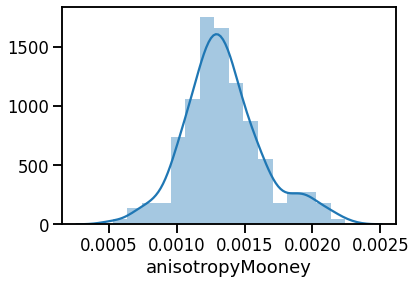

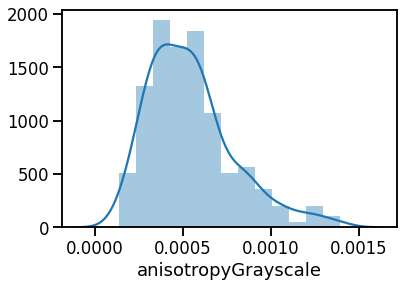

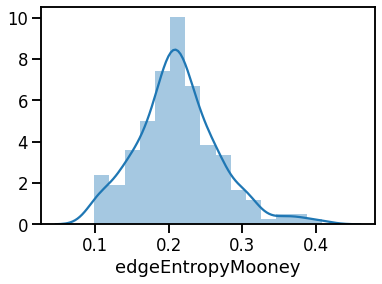

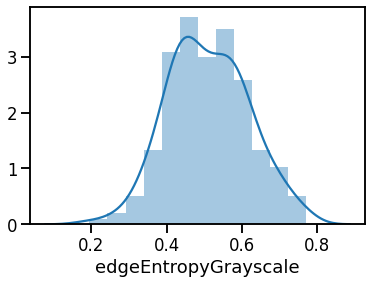

In [405]:

for measure in dfim.columns:
    if measure== 'currentStim' or measure =='imgName': 
        continue
    plt.figure()
    sns.distplot(dfim[measure])
   

## Memorability scores (Lore)

TODO